In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
import warnings
warnings.filterwarnings('ignore')
from src.data.loader import load_feature_vector_data
import random
from src.visualisation.price_plotter import plot_token_price

In [2]:
# Read data
df = load_feature_vector_data()

# Select features for clustering
features = ['trade_frequency', 'average_trade_size', 'unique_traders',
            'max_market_cap', 'initial_liquidity', 'price_volatility',
            'total_trades', 'lifetime_seconds']

# Create feature matrix
X = df[features]

# Display basic statistics
X.describe()

# %%
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.describe()

trade_frequency  average_trade_size  unique_traders  max_market_cap  \
count     2.000000e+03        2.000000e+03    2.000000e+03    2.000000e+03   
mean      6.306067e-17        3.375078e-17   -1.953993e-17   -3.765876e-16   
std       1.000250e+00        1.000250e+00    1.000250e+00    1.000250e+00   
min      -8.369030e-01       -9.109651e-01   -1.284566e+00   -5.824156e+00   
25%      -7.762369e-01       -7.225155e-01   -6.567621e-01   -3.479415e-01   
50%      -4.047609e-01       -6.395506e-01   -5.689212e-01    5.382701e-02   
75%       4.321458e-01        1.073489e+00    7.228572e-01    4.473814e-01   
max       4.086236e+00        3.160169e+00    7.176582e+00    1.179765e+00   

       initial_liquidity  price_volatility  total_trades  lifetime_seconds  
count       2.000000e+03      2.000000e+03  2.000000e+03      2.000000e+03  
mean        1.065814e-17      1.385558e-16 -3.064216e-17     -8.171241e-17  
std         1.000250e+00      1.000250e+00  1.000250e+00      1.000250e+00  
min        -4.018323e-01     -2.523603e+00 -6.304490e-01     -8.889618e-01  
25%        -1.913036e-01     -5.547556e-01 -4.480422e-01     -8.223050e-01  
50%        -1.913036e-01     -1.075059e-01 -1.858745e-01     -4.051641e-01  
75%        -1.336876e-01      3.838653e-01  9.884159e-02      5.539947e-01  
max         1.223043e+01      4.572273e+00  2.446294e+01      3.235663e+00

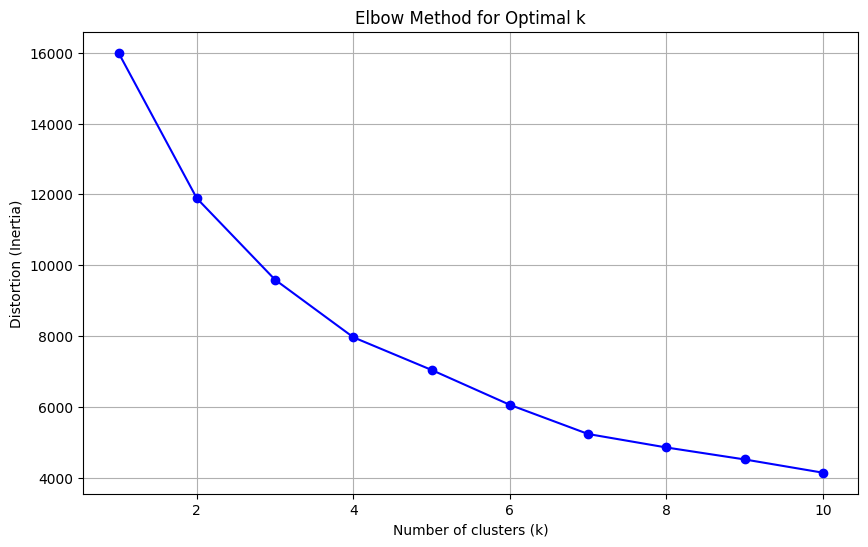

Based on the second derivative of the curve, the suggested optimal k is: 2


In [3]:
# Function to calculate and plot the elbow method
def plot_elbow_method(X, max_k=10):
    distortions = []
    K_range = range(1, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, distortions, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()
    
    # Calculate the rate of change (approximate second derivative)
    diffs = np.diff(distortions)
    diffs_of_diffs = np.diff(diffs)
    k_optimal = np.argmax(np.abs(diffs_of_diffs)) + 2
    
    print(f"Based on the second derivative of the curve, the suggested optimal k is: {k_optimal}")
    return distortions

# Run the elbow method
distortions = plot_elbow_method(X_scaled)

For k=2, the silhouette score is 0.386
For k=3, the silhouette score is 0.405
For k=4, the silhouette score is 0.417
For k=5, the silhouette score is 0.425
For k=6, the silhouette score is 0.389
For k=7, the silhouette score is 0.398
For k=8, the silhouette score is 0.406
For k=9, the silhouette score is 0.329
For k=10, the silhouette score is 0.411


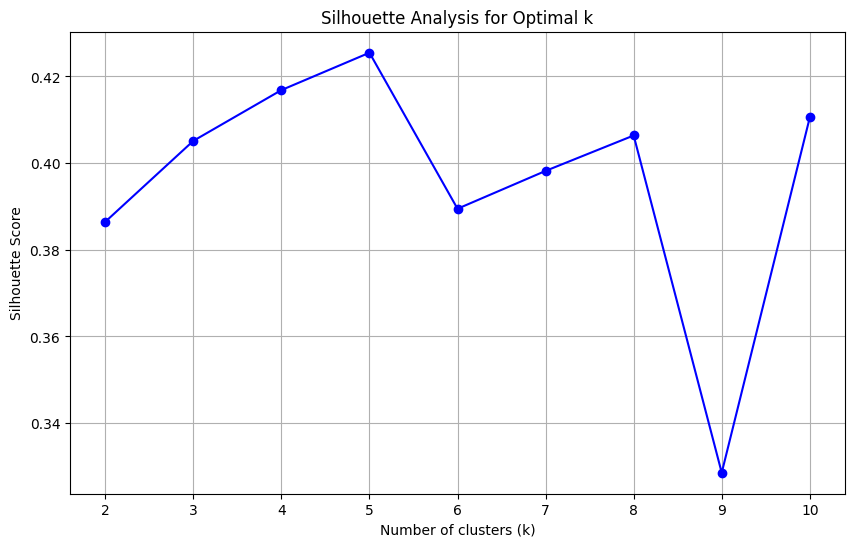

The optimal number of clusters based on silhouette score is: 5


In [4]:
# Function to calculate silhouette scores for different k values
def calculate_silhouette_scores(X, max_k=10):
    silhouette_scores = []
    K_range = range(2, max_k + 1)  # Silhouette score requires at least 2 clusters
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For k={k}, the silhouette score is {silhouette_avg:.3f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.grid(True)
    plt.show()
    
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"The optimal number of clusters based on silhouette score is: {optimal_k}")
    return silhouette_scores, optimal_k

# Calculate silhouette scores
silhouette_scores, optimal_k_silhouette = calculate_silhouette_scores(X_scaled)

For k=5, the average silhouette score is: 0.425


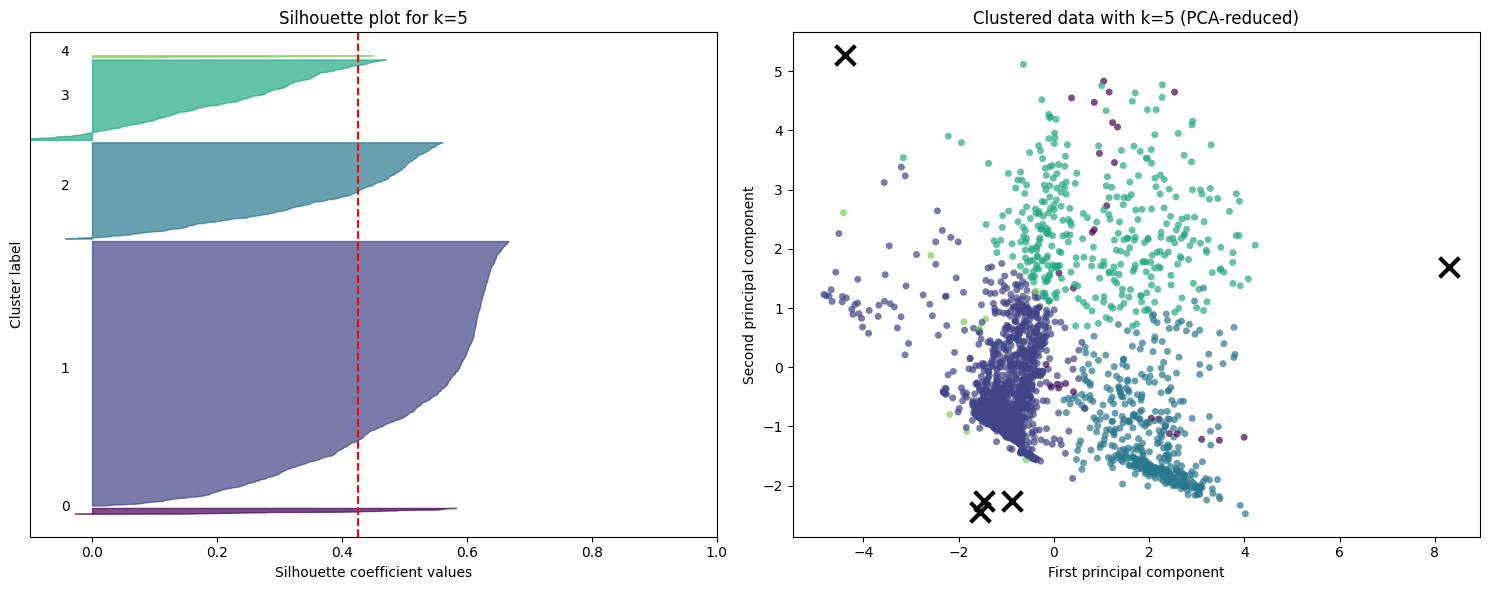

In [5]:
# Detailed silhouette plot for the optimal k
def plot_silhouette_analysis(X, optimal_k):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Run the KMeans clustering with the optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # The silhouette_score gives the average value for all the samples
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For k={optimal_k}, the average silhouette score is: {silhouette_avg:.3f}")
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(optimal_k):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.viridis(float(i) / optimal_k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
    
    ax1.set_title(f"Silhouette plot for k={optimal_k}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    
    # Visualize clusters with PCA for the rightmost plot
    pca = PCA(n_components=2).fit_transform(X)
    
    # Create a scatter plot of the data points
    colors = plt.cm.viridis(cluster_labels.astype(float) / optimal_k)
    ax2.scatter(pca[:, 0], pca[:, 1], marker='.', s=100, lw=0, alpha=0.7, c=colors)
    
    # Plot the centroids
    centroids = kmeans.cluster_centers_
    centroids_pca = PCA(n_components=2).fit_transform(centroids)
    ax2.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x',
                s=200, linewidths=3, color='black')
    
    ax2.set_title(f"Clustered data with k={optimal_k} (PCA-reduced)")
    ax2.set_xlabel("First principal component")
    ax2.set_ylabel("Second principal component")
    
    plt.tight_layout()
    plt.show()

# Plot silhouette analysis for the optimal k
plot_silhouette_analysis(X_scaled, optimal_k_silhouette)

Optimal k based on Silhouette Score: 5
Optimal k based on Calinski-Harabasz Index: 2
Optimal k based on Davies-Bouldin Index: 8


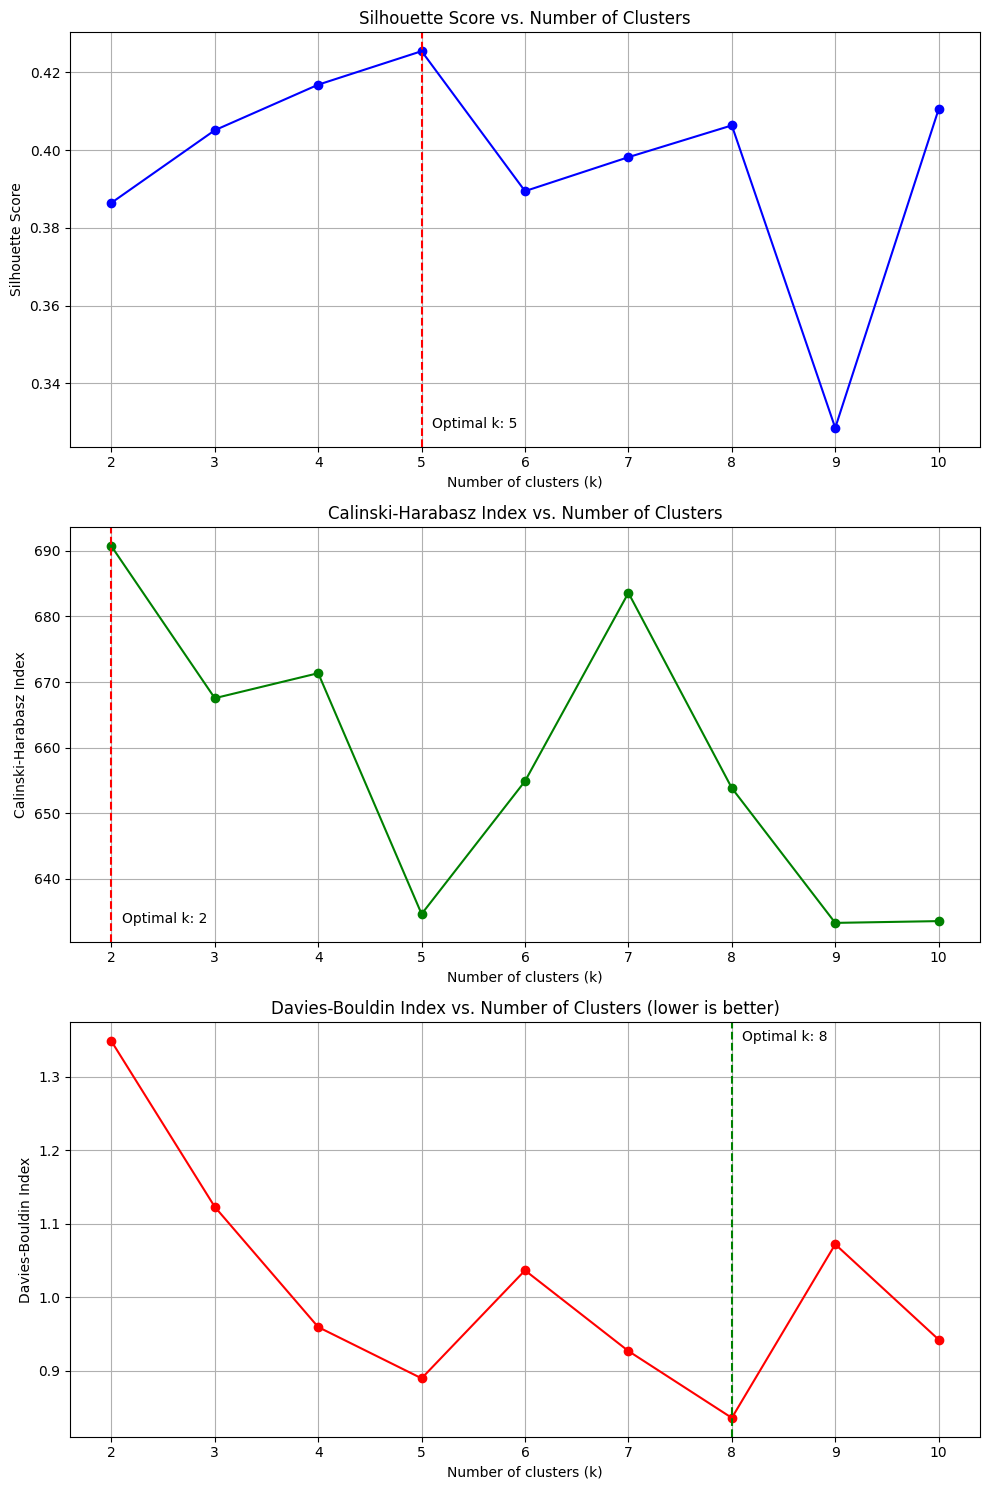

In [6]:
# Evaluate K-means with multiple metrics
def evaluate_kmeans_with_multiple_metrics(X, max_k=10):
    K_range = range(2, max_k + 1)
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        # Calculate metrics
        silhouette_scores.append(silhouette_score(X, labels))
        calinski_scores.append(calinski_harabasz_score(X, labels))
        davies_bouldin_scores.append(davies_bouldin_score(X, labels))
    
    # Create a DataFrame to hold all metrics
    metrics_df = pd.DataFrame({
        'k': list(K_range),
        'silhouette': silhouette_scores,
        'calinski_harabasz': calinski_scores,
        'davies_bouldin': davies_bouldin_scores
    })
    
    # For most metrics, higher is better
    optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
    optimal_k_calinski = K_range[np.argmax(calinski_scores)]
    # For Davies-Bouldin, lower is better
    optimal_k_davies = K_range[np.argmin(davies_bouldin_scores)]
    
    print(f"Optimal k based on Silhouette Score: {optimal_k_silhouette}")
    print(f"Optimal k based on Calinski-Harabasz Index: {optimal_k_calinski}")
    print(f"Optimal k based on Davies-Bouldin Index: {optimal_k_davies}")
    
    # Plot all metrics
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    
    # Plot Silhouette Score (higher is better)
    axes[0].plot(K_range, silhouette_scores, 'bo-')
    axes[0].set_xlabel('Number of clusters (k)')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].set_title('Silhouette Score vs. Number of Clusters')
    axes[0].axvline(x=optimal_k_silhouette, color='r', linestyle='--')
    axes[0].text(optimal_k_silhouette+0.1, min(silhouette_scores), f'Optimal k: {optimal_k_silhouette}')
    axes[0].grid(True)
    
    # Plot Calinski-Harabasz Index (higher is better)
    axes[1].plot(K_range, calinski_scores, 'go-')
    axes[1].set_xlabel('Number of clusters (k)')
    axes[1].set_ylabel('Calinski-Harabasz Index')
    axes[1].set_title('Calinski-Harabasz Index vs. Number of Clusters')
    axes[1].axvline(x=optimal_k_calinski, color='r', linestyle='--')
    axes[1].text(optimal_k_calinski+0.1, min(calinski_scores), f'Optimal k: {optimal_k_calinski}')
    axes[1].grid(True)
    
    # Plot Davies-Bouldin Index (lower is better)
    axes[2].plot(K_range, davies_bouldin_scores, 'ro-')
    axes[2].set_xlabel('Number of clusters (k)')
    axes[2].set_ylabel('Davies-Bouldin Index')
    axes[2].set_title('Davies-Bouldin Index vs. Number of Clusters (lower is better)')
    axes[2].axvline(x=optimal_k_davies, color='g', linestyle='--')
    axes[2].text(optimal_k_davies+0.1, max(davies_bouldin_scores), f'Optimal k: {optimal_k_davies}')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Evaluate K-means with multiple metrics
metrics_df = evaluate_kmeans_with_multiple_metrics(X_scaled)

Cluster Centers for k=5:
   trade_frequency  average_trade_size  unique_traders  max_market_cap  \
0       365.535147            0.322541      869.962963       76.366245   
1       117.779745            0.053927      269.795242       68.558243   
2        87.839033            0.483550      995.247086       79.842653   
3       638.633900            0.301427      648.081006       67.178122   
4        64.486520            0.046695      489.444444       66.130137   

   initial_liquidity  price_volatility  total_trades  lifetime_seconds  
0          39.556788      2.429717e-08   2601.148148      9.017721e+05  
1           1.195756      3.928832e-08   2952.225998      3.478951e+05  
2           1.844912      6.585111e-08   2806.757576      2.482162e+05  
3           1.496433      4.825050e-08   2690.821229      1.658076e+06  
4           1.903455      1.989303e-08  17876.666667      9.606536e+05  


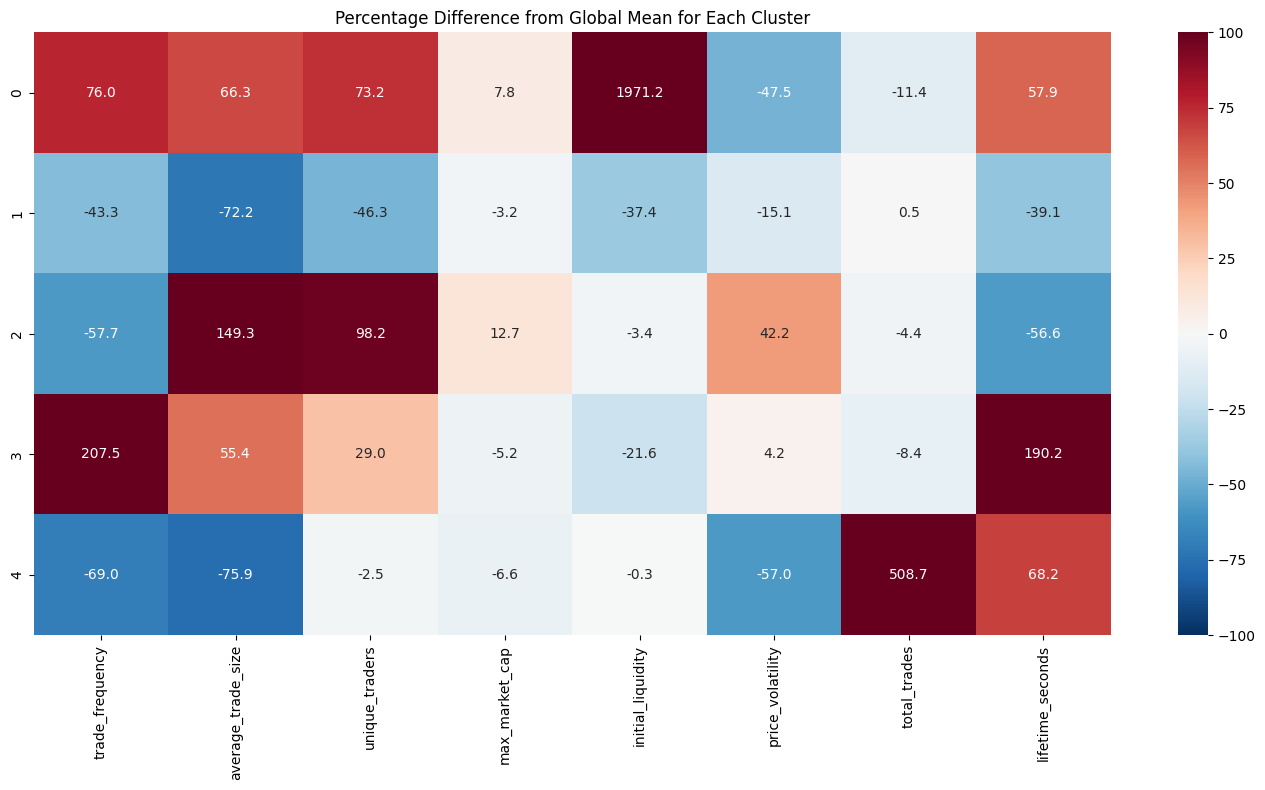

In [7]:
# Picking 5 as a middle ground
best_k = 5
# Now let's visualize and analyze this optimal clustering
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)
# Get cluster centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                             columns=features)
# Print cluster centers
print(f"Cluster Centers for k={best_k}:")
print(cluster_centers)

# Calculate relative differences from the global mean
global_means = df[features].mean()
relative_differences = pd.DataFrame(index=range(best_k), columns=features)

for i in range(best_k):
    for feature in features:
        try:
            # Convert values to float and calculate percentage difference
            center_val = float(cluster_centers.loc[i, feature])
            mean_val = float(global_means[feature])
            
            # Prevent division by zero
            if mean_val != 0:
                relative_differences.loc[i, feature] = ((center_val - mean_val) / mean_val) * 100
            else:
                relative_differences.loc[i, feature] = 0
        except (ValueError, TypeError):
            # Handle any conversion errors
            print(f"Warning: Could not process feature {feature} for cluster {i}")
            relative_differences.loc[i, feature] = 0

# Convert all values to numeric, replacing any errors with zeros
relative_differences = relative_differences.apply(pd.to_numeric, errors='coerce').fillna(0)

# Plot heatmap of relative differences
plt.figure(figsize=(14, 8))
sns.heatmap(relative_differences, annot=True, cmap='RdBu_r', fmt='.1f', 
            center=0, vmin=-100, vmax=100)
plt.title('Percentage Difference from Global Mean for Each Cluster')
plt.tight_layout()
plt.show()

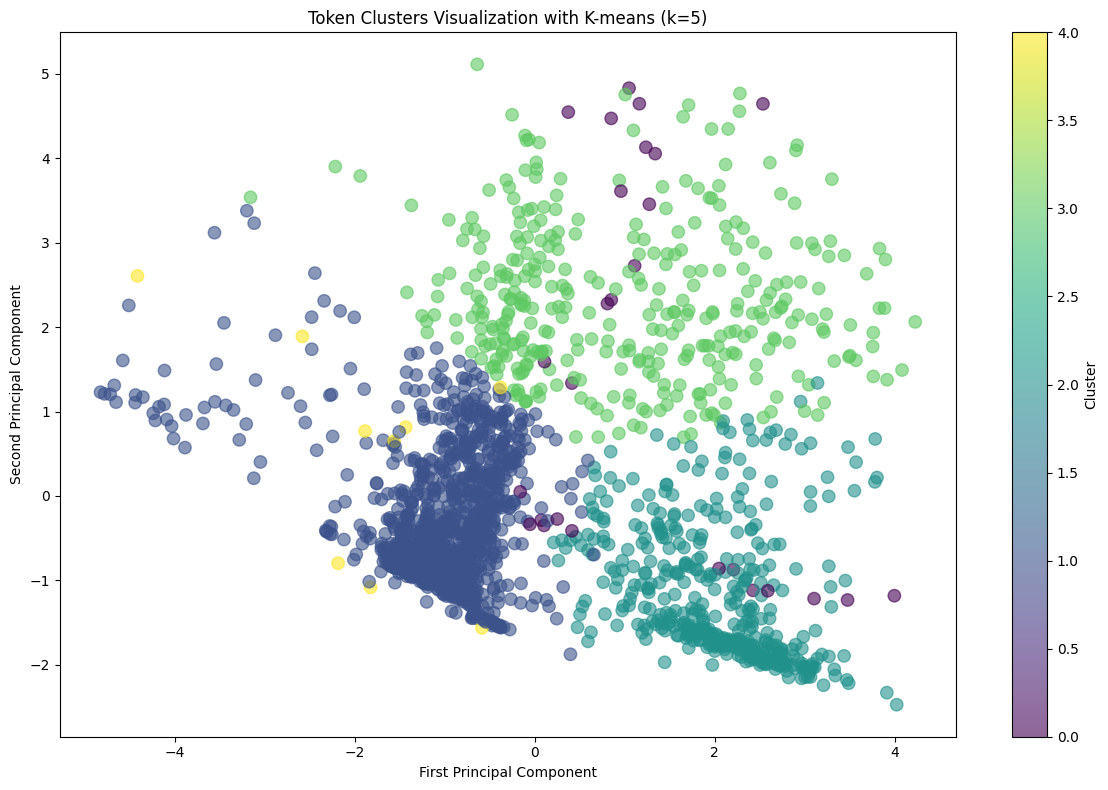

In [8]:
# Visualize the clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], 
                      cmap='viridis', alpha=0.6, s=80)
plt.title(f'Token Clusters Visualization with K-means (k={best_k})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

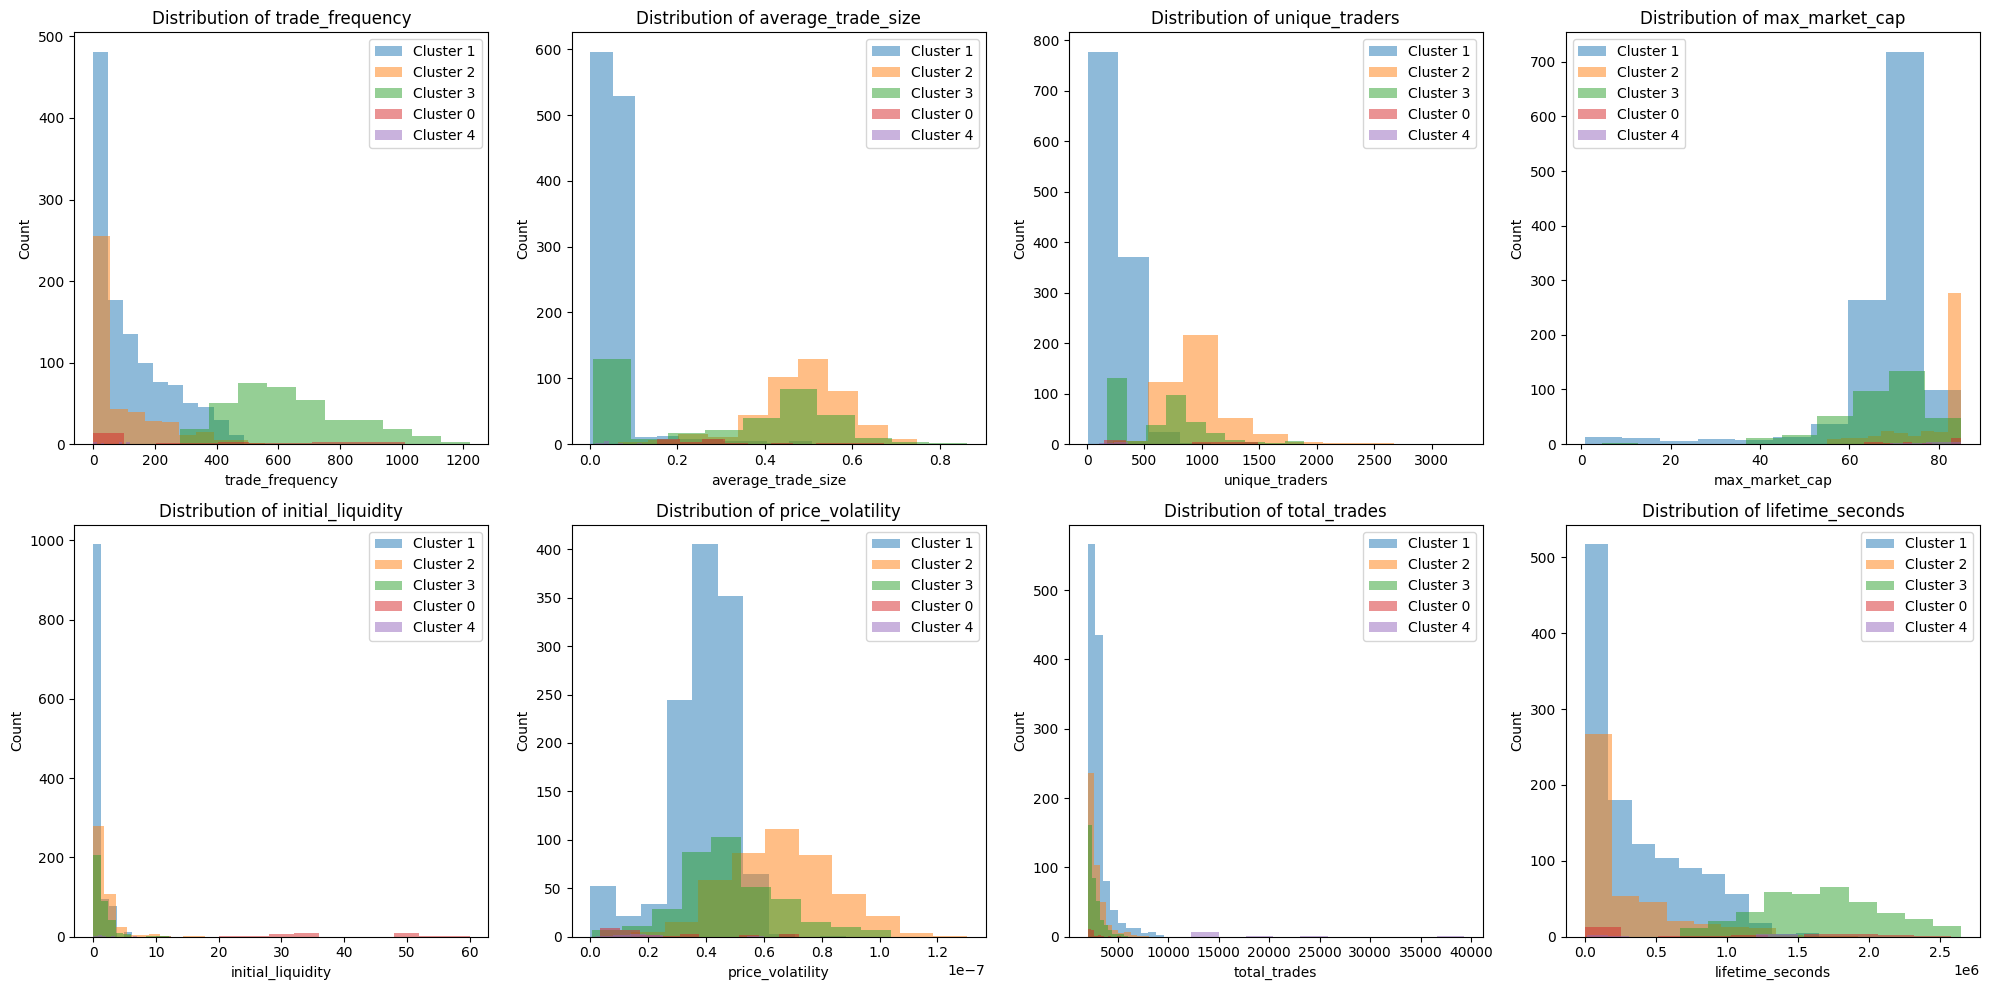

In [9]:
# Feature distributions by cluster
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    for cluster in df['cluster'].unique():
        subset = df[df['cluster'] == cluster]
        axes[i].hist(subset[feature], alpha=0.5, label=f'Cluster {cluster}')
    
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [10]:
# Train the final model
def train_final_kmeans_model(X, k):
    # Train the final model with the optimal k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    
    print(f"Final K-means model trained with k={k}")
    print(f"Inertia: {kmeans.inertia_:.2f}")
    
    # Return the model for future use
    return kmeans

# Train the final model
final_model = train_final_kmeans_model(X_scaled, best_k)

# Summary of findings
print("\nSummary of Cluster Analysis:")
print(f"Best number of clusters (k): {best_k}")
print("\nCluster sizes:")
print(df['cluster'].value_counts().sort_index())

Final K-means model trained with k=5
Inertia: 7041.04

Summary of Cluster Analysis:
Best number of clusters (k): 5

Cluster sizes:
cluster
0      27
1    1177
2     429
3     358
4       9
Name: count, dtype: int64


In [11]:
# Create a summary of each cluster's characteristics
cluster_profiles = []

for i in range(best_k):
    cluster_tokens = df[df['cluster'] == i]
    
    # Get the top distinguishing features for this cluster
    cluster_center = kmeans.cluster_centers_[i]
    # Calculate the distance from the global mean for each feature
    global_mean = np.mean(X_scaled, axis=0)
    feature_deviations = cluster_center - global_mean
    # Get the features with the largest absolute deviation
    sorted_features = np.argsort(-np.abs(feature_deviations))
    distinguishing_features = [features[j] for j in sorted_features[:3]]
    
    profile = {
        'Cluster': i,
        'Size': len(cluster_tokens),
        'Percentage': f"{100 * len(cluster_tokens) / len(df):.1f}%",
        'Top Features': distinguishing_features,
        'Description': ""
    }
    
    # Create a qualitative description
    description = f"Cluster {i} is characterized by "
    for j, feature in enumerate(distinguishing_features):
        direction = "high" if feature_deviations[sorted_features[j]] > 0 else "low"
        description += f"{direction} {feature}"
        if j < len(distinguishing_features) - 1:
            description += ", "
            
    profile['Description'] = description
    cluster_profiles.append(profile)
    
# Create a DataFrame with cluster profiles
profiles_df = pd.DataFrame(cluster_profiles)
print("\nCluster Profiles:")

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Print the complete DataFrame
print(profiles_df[['Cluster', 'Size', 'Percentage', 'Top Features', 'Description']])

# Reset to defaults after printing
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')


Cluster Profiles:
   Cluster  Size Percentage  \
0        0    27       1.4%   
1        1  1177      58.9%   
2        2   429      21.4%   
3        3   358      17.9%   
4        4     9       0.5%   

                                              Top Features  \
0    [initial_liquidity, price_volatility, unique_traders]   
1   [average_trade_size, unique_traders, price_volatility]   
2   [average_trade_size, unique_traders, price_volatility]   
3  [trade_frequency, lifetime_seconds, average_trade_size]   
4     [total_trades, price_volatility, average_trade_size]   

                                                                                          Description  
0     Cluster 0 is characterized by high initial_liquidity, low price_volatility, high unique_traders  
1      Cluster 1 is characterized by low average_trade_size, low unique_traders, low price_volatility  
2   Cluster 2 is characterized by high average_trade_size, high unique_traders, high price_volatility  
3  Cl

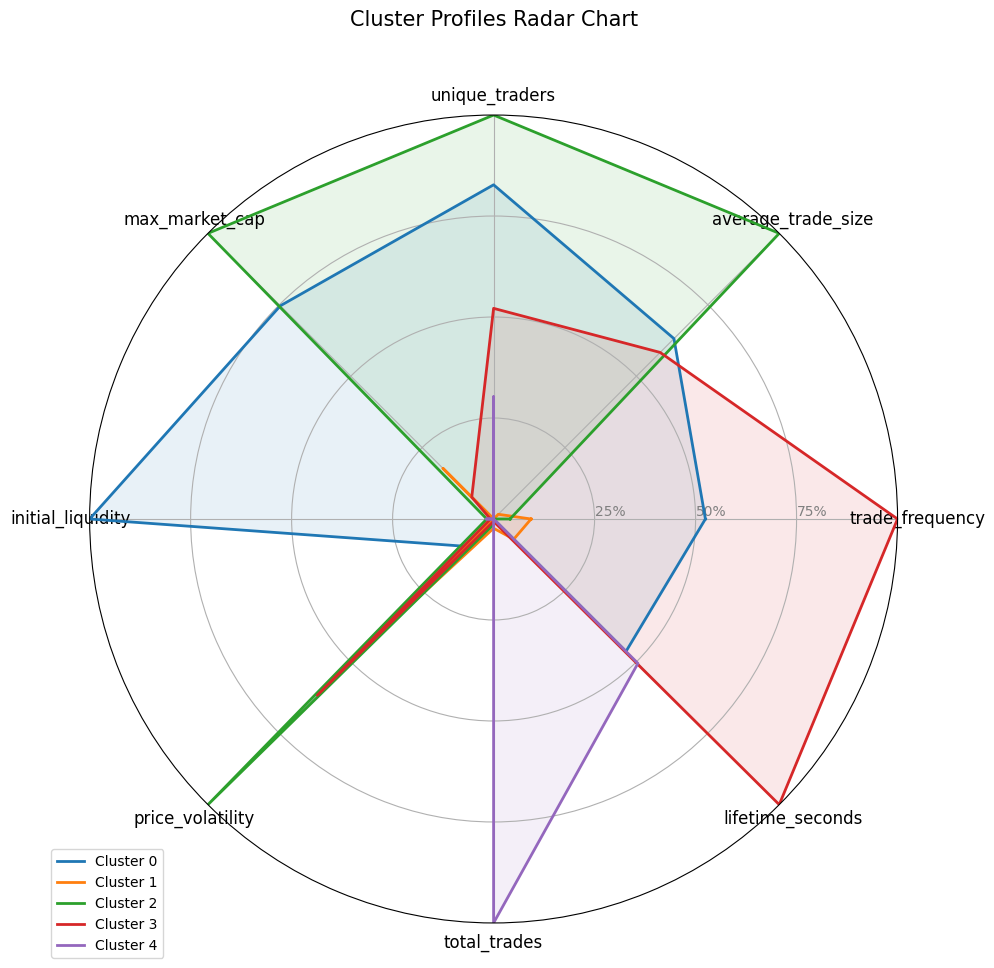

In [12]:
# Visualize the final clusters with a radar chart
def plot_radar_chart(cluster_centers, features, n_clusters):
    # Number of variables
    N = len(features)
    
    # What will be the angle of each axis in the plot (divide the plot into equal parts)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], features, size=12)
    
    # Draw the y-axis labels (0-100%)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Plot each cluster
    for i in range(n_clusters):
        # Normalize the cluster center values for radar chart (0-1 scale)
        values = cluster_centers.iloc[i].values.tolist()
        min_vals = cluster_centers.min()
        max_vals = cluster_centers.max()
        normalized_values = [(val - min_val) / (max_val - min_val) if max_val > min_val else 0.5 
                           for val, min_val, max_val in zip(values, min_vals, max_vals)]
        
        normalized_values += normalized_values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, normalized_values, linewidth=2, linestyle='solid', label=f"Cluster {i}")
        ax.fill(angles, normalized_values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Cluster Profiles Radar Chart", size=15, y=1.1)
    
    plt.tight_layout()
    plt.show()

# Plot radar chart
plot_radar_chart(cluster_centers, features, best_k)

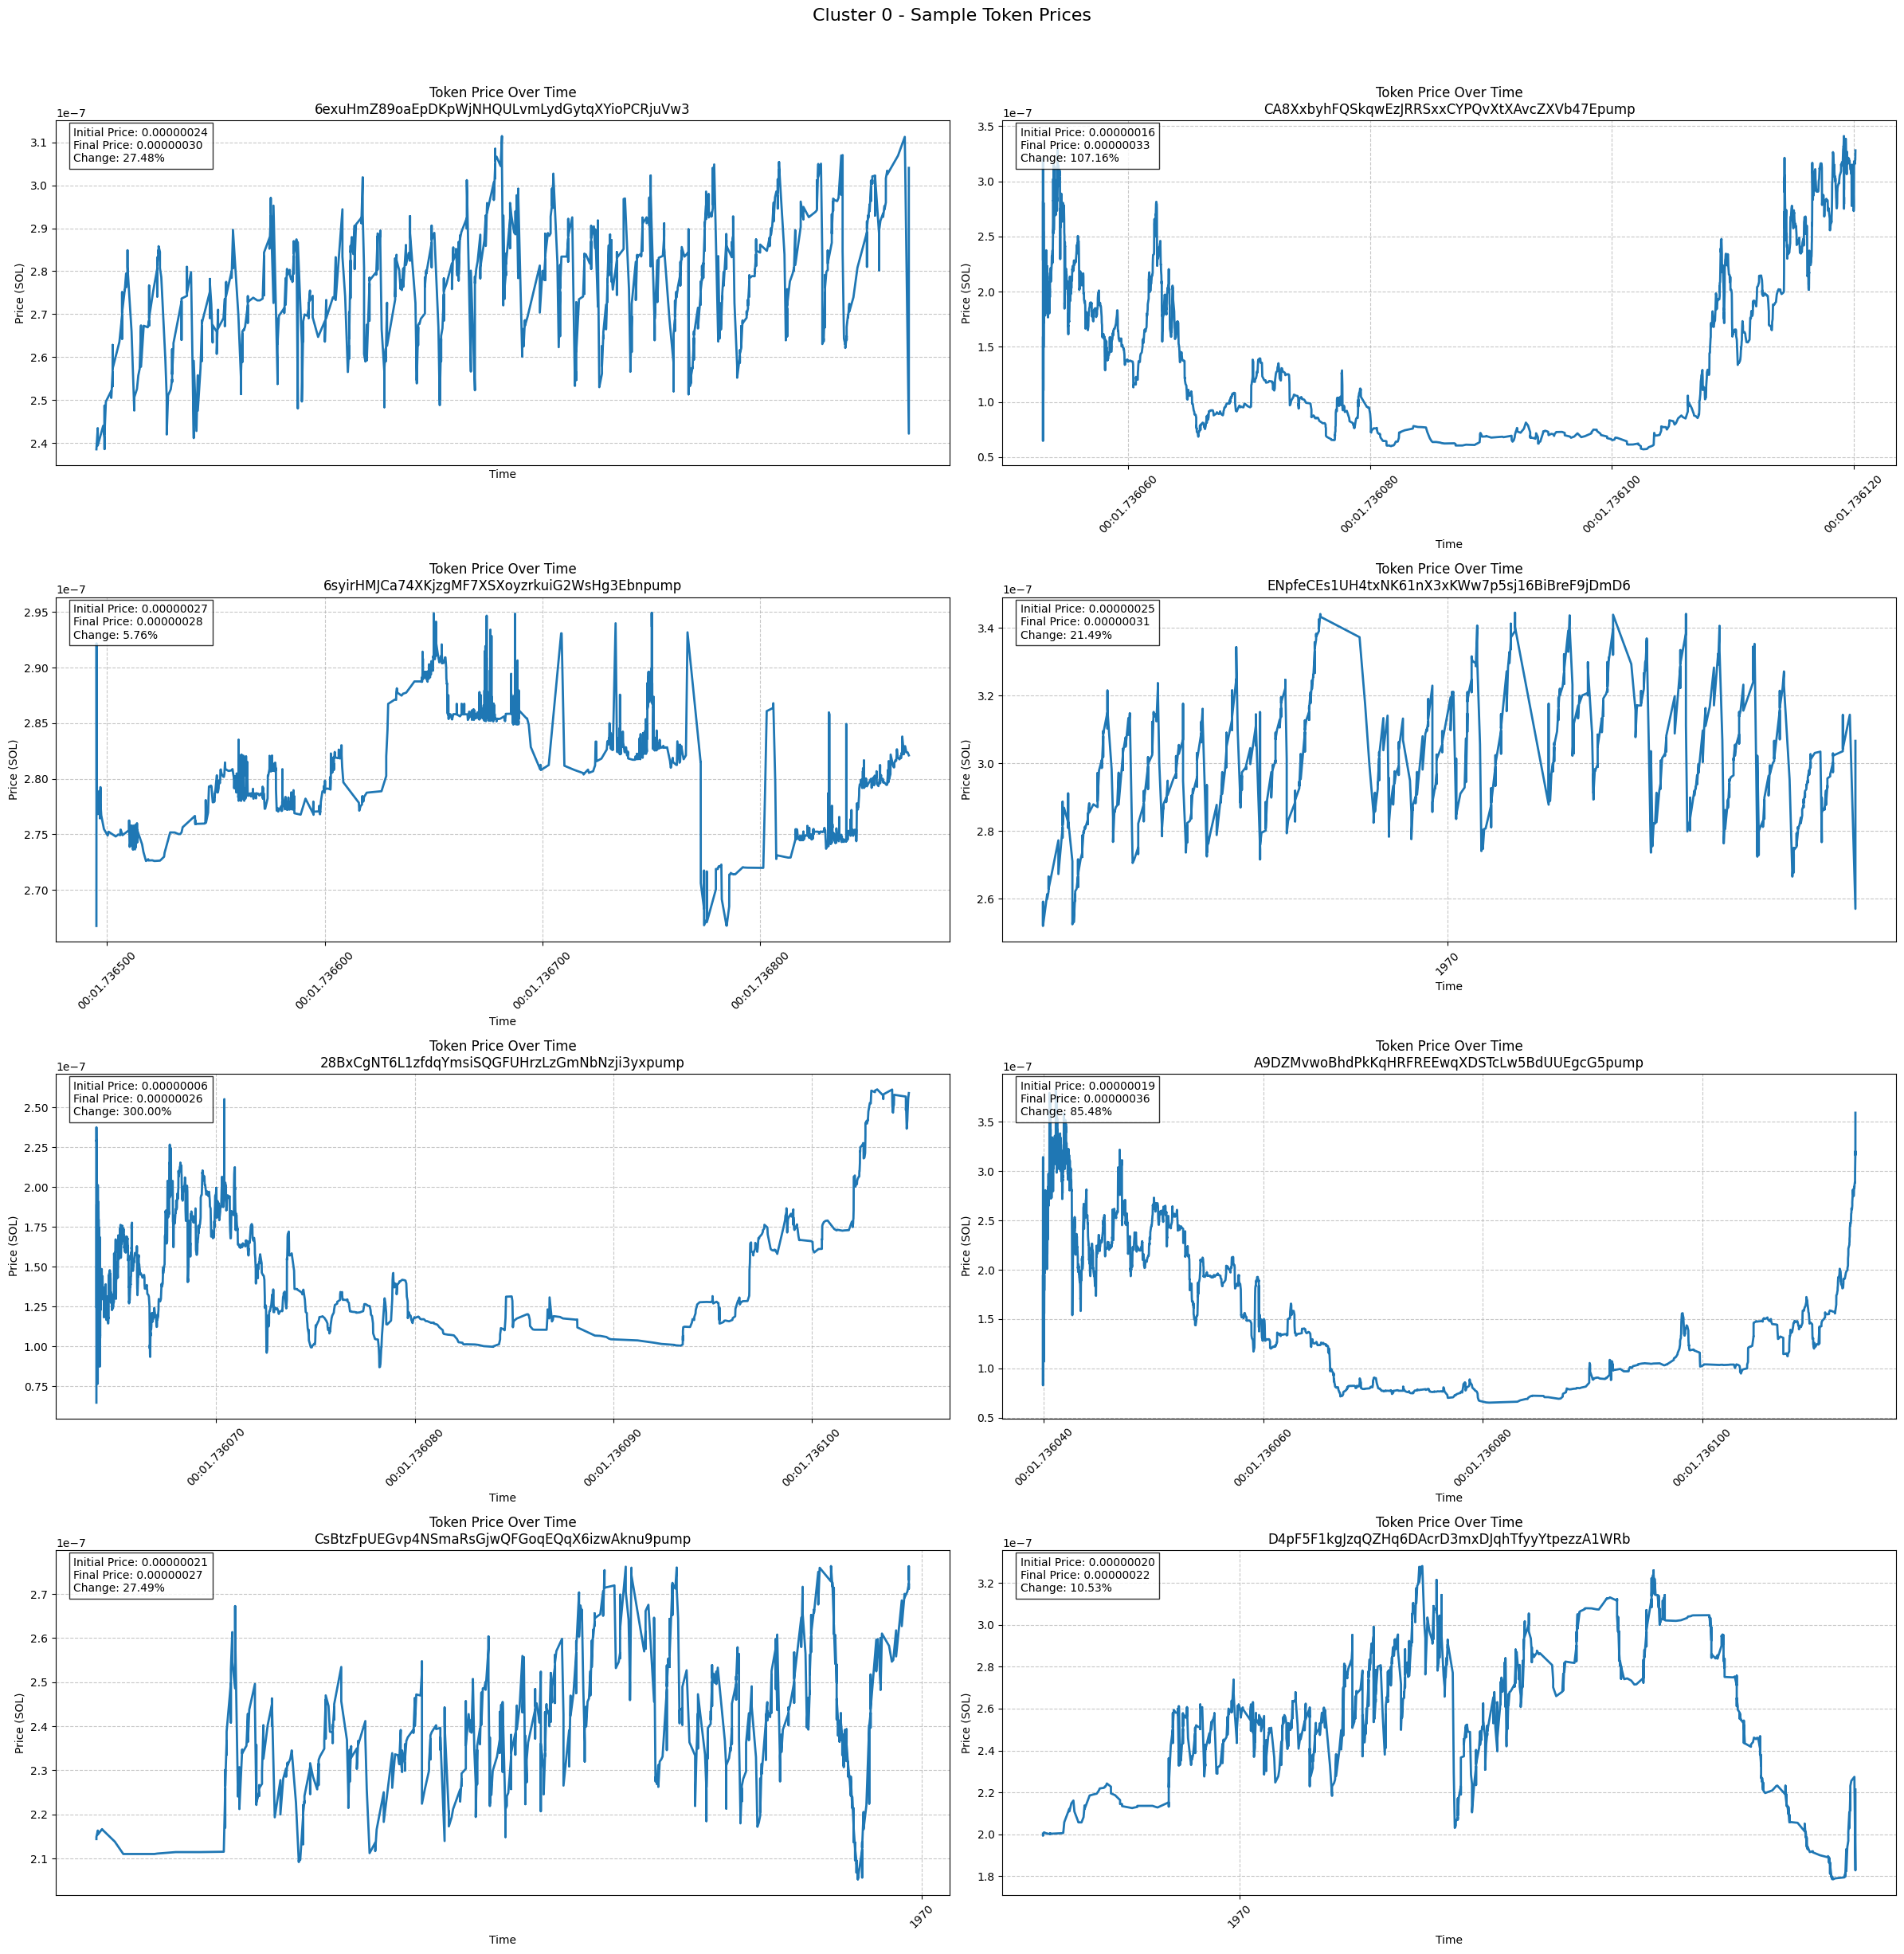

Created price plot for 8 tokens from cluster 0


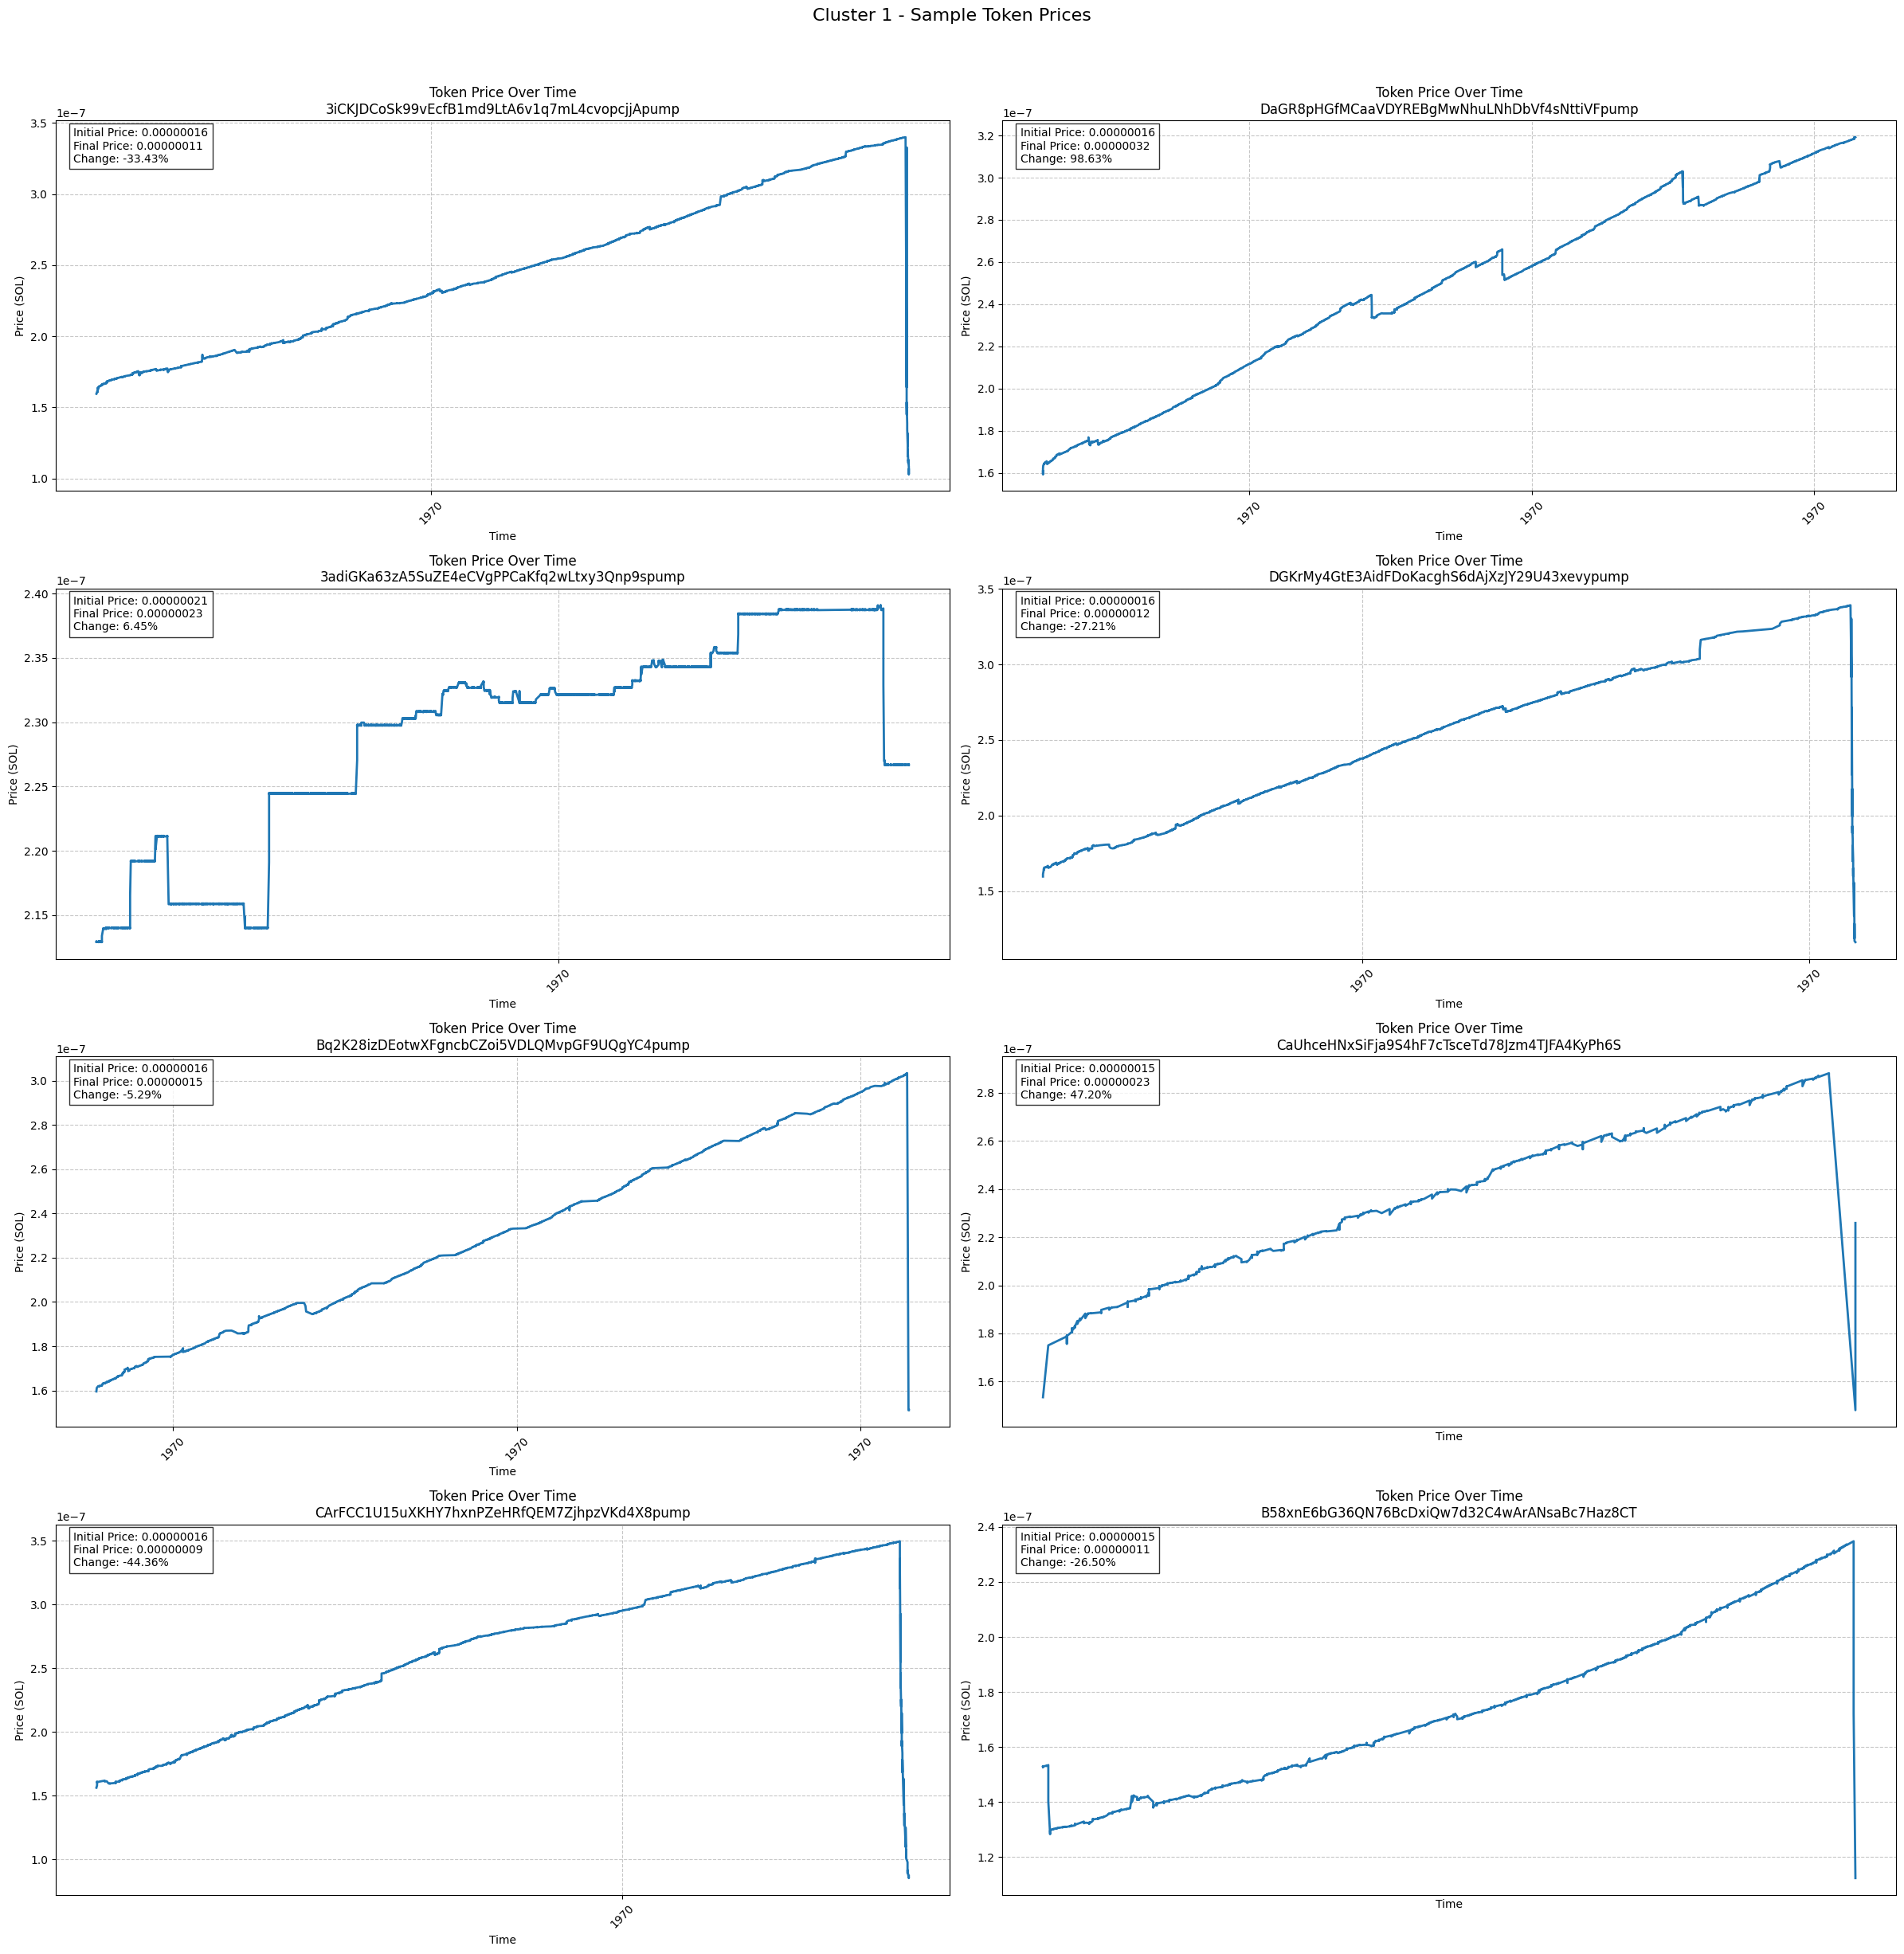

Created price plot for 8 tokens from cluster 1


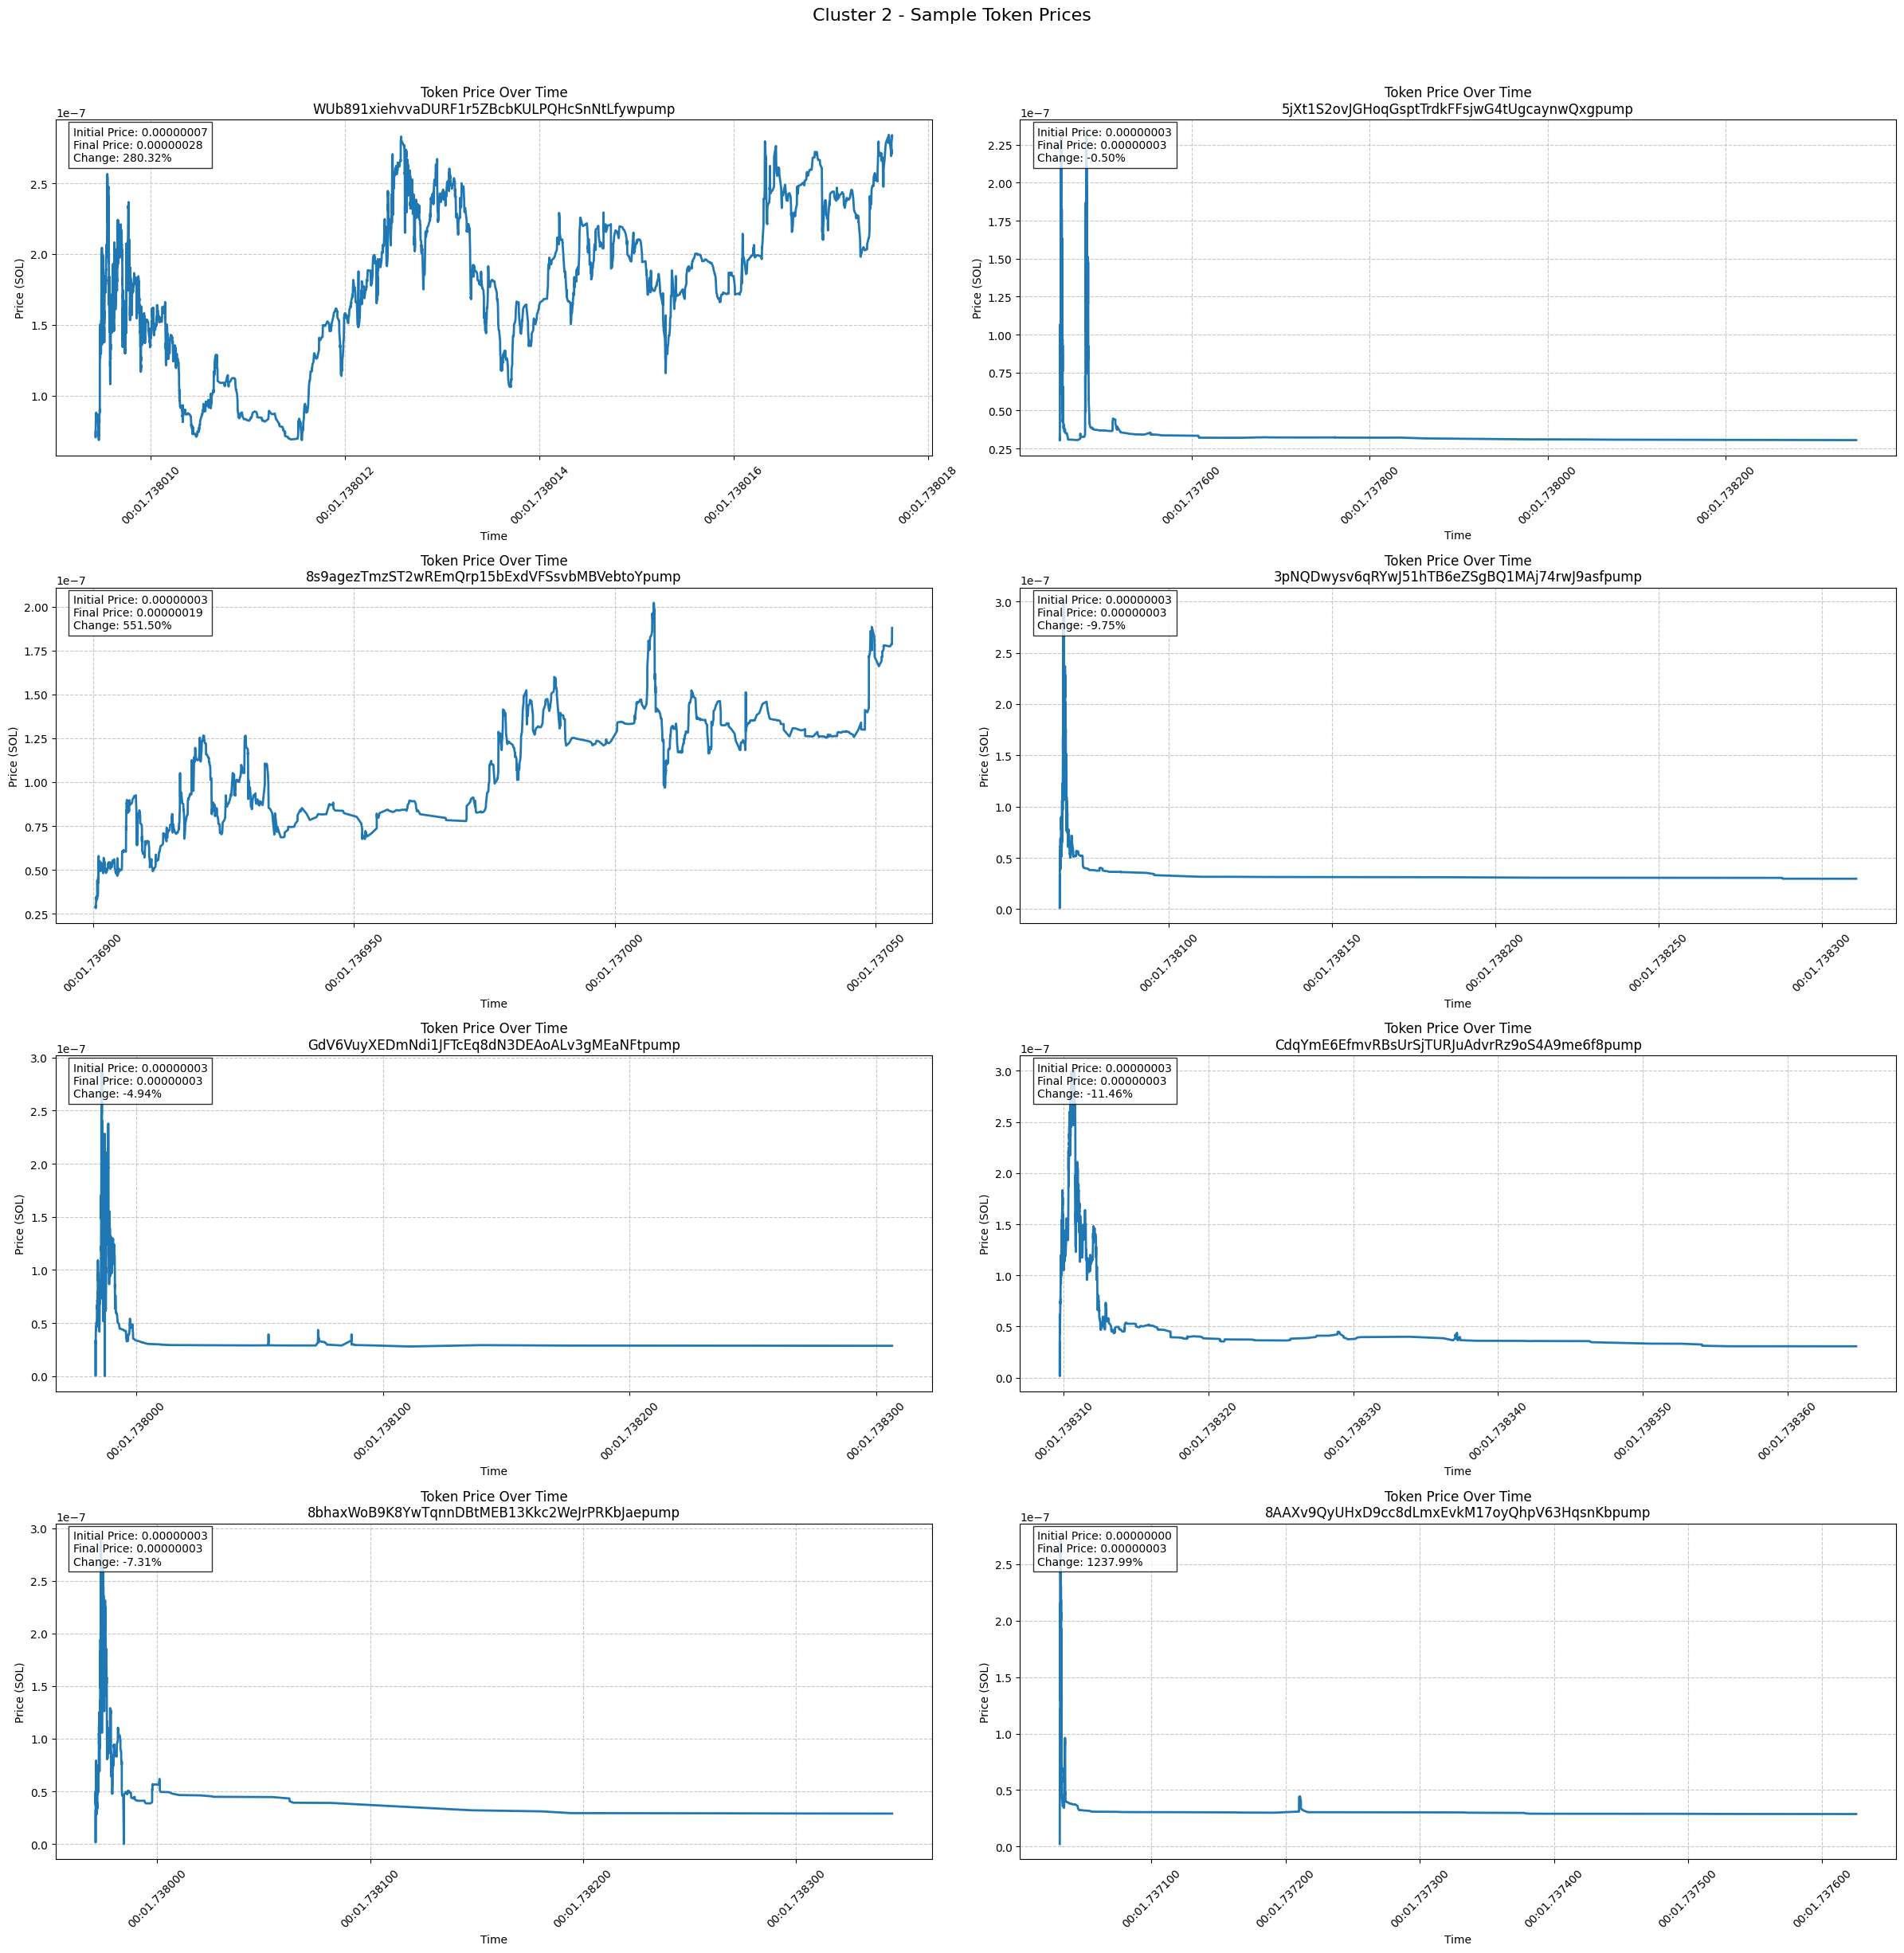

Created price plot for 8 tokens from cluster 2


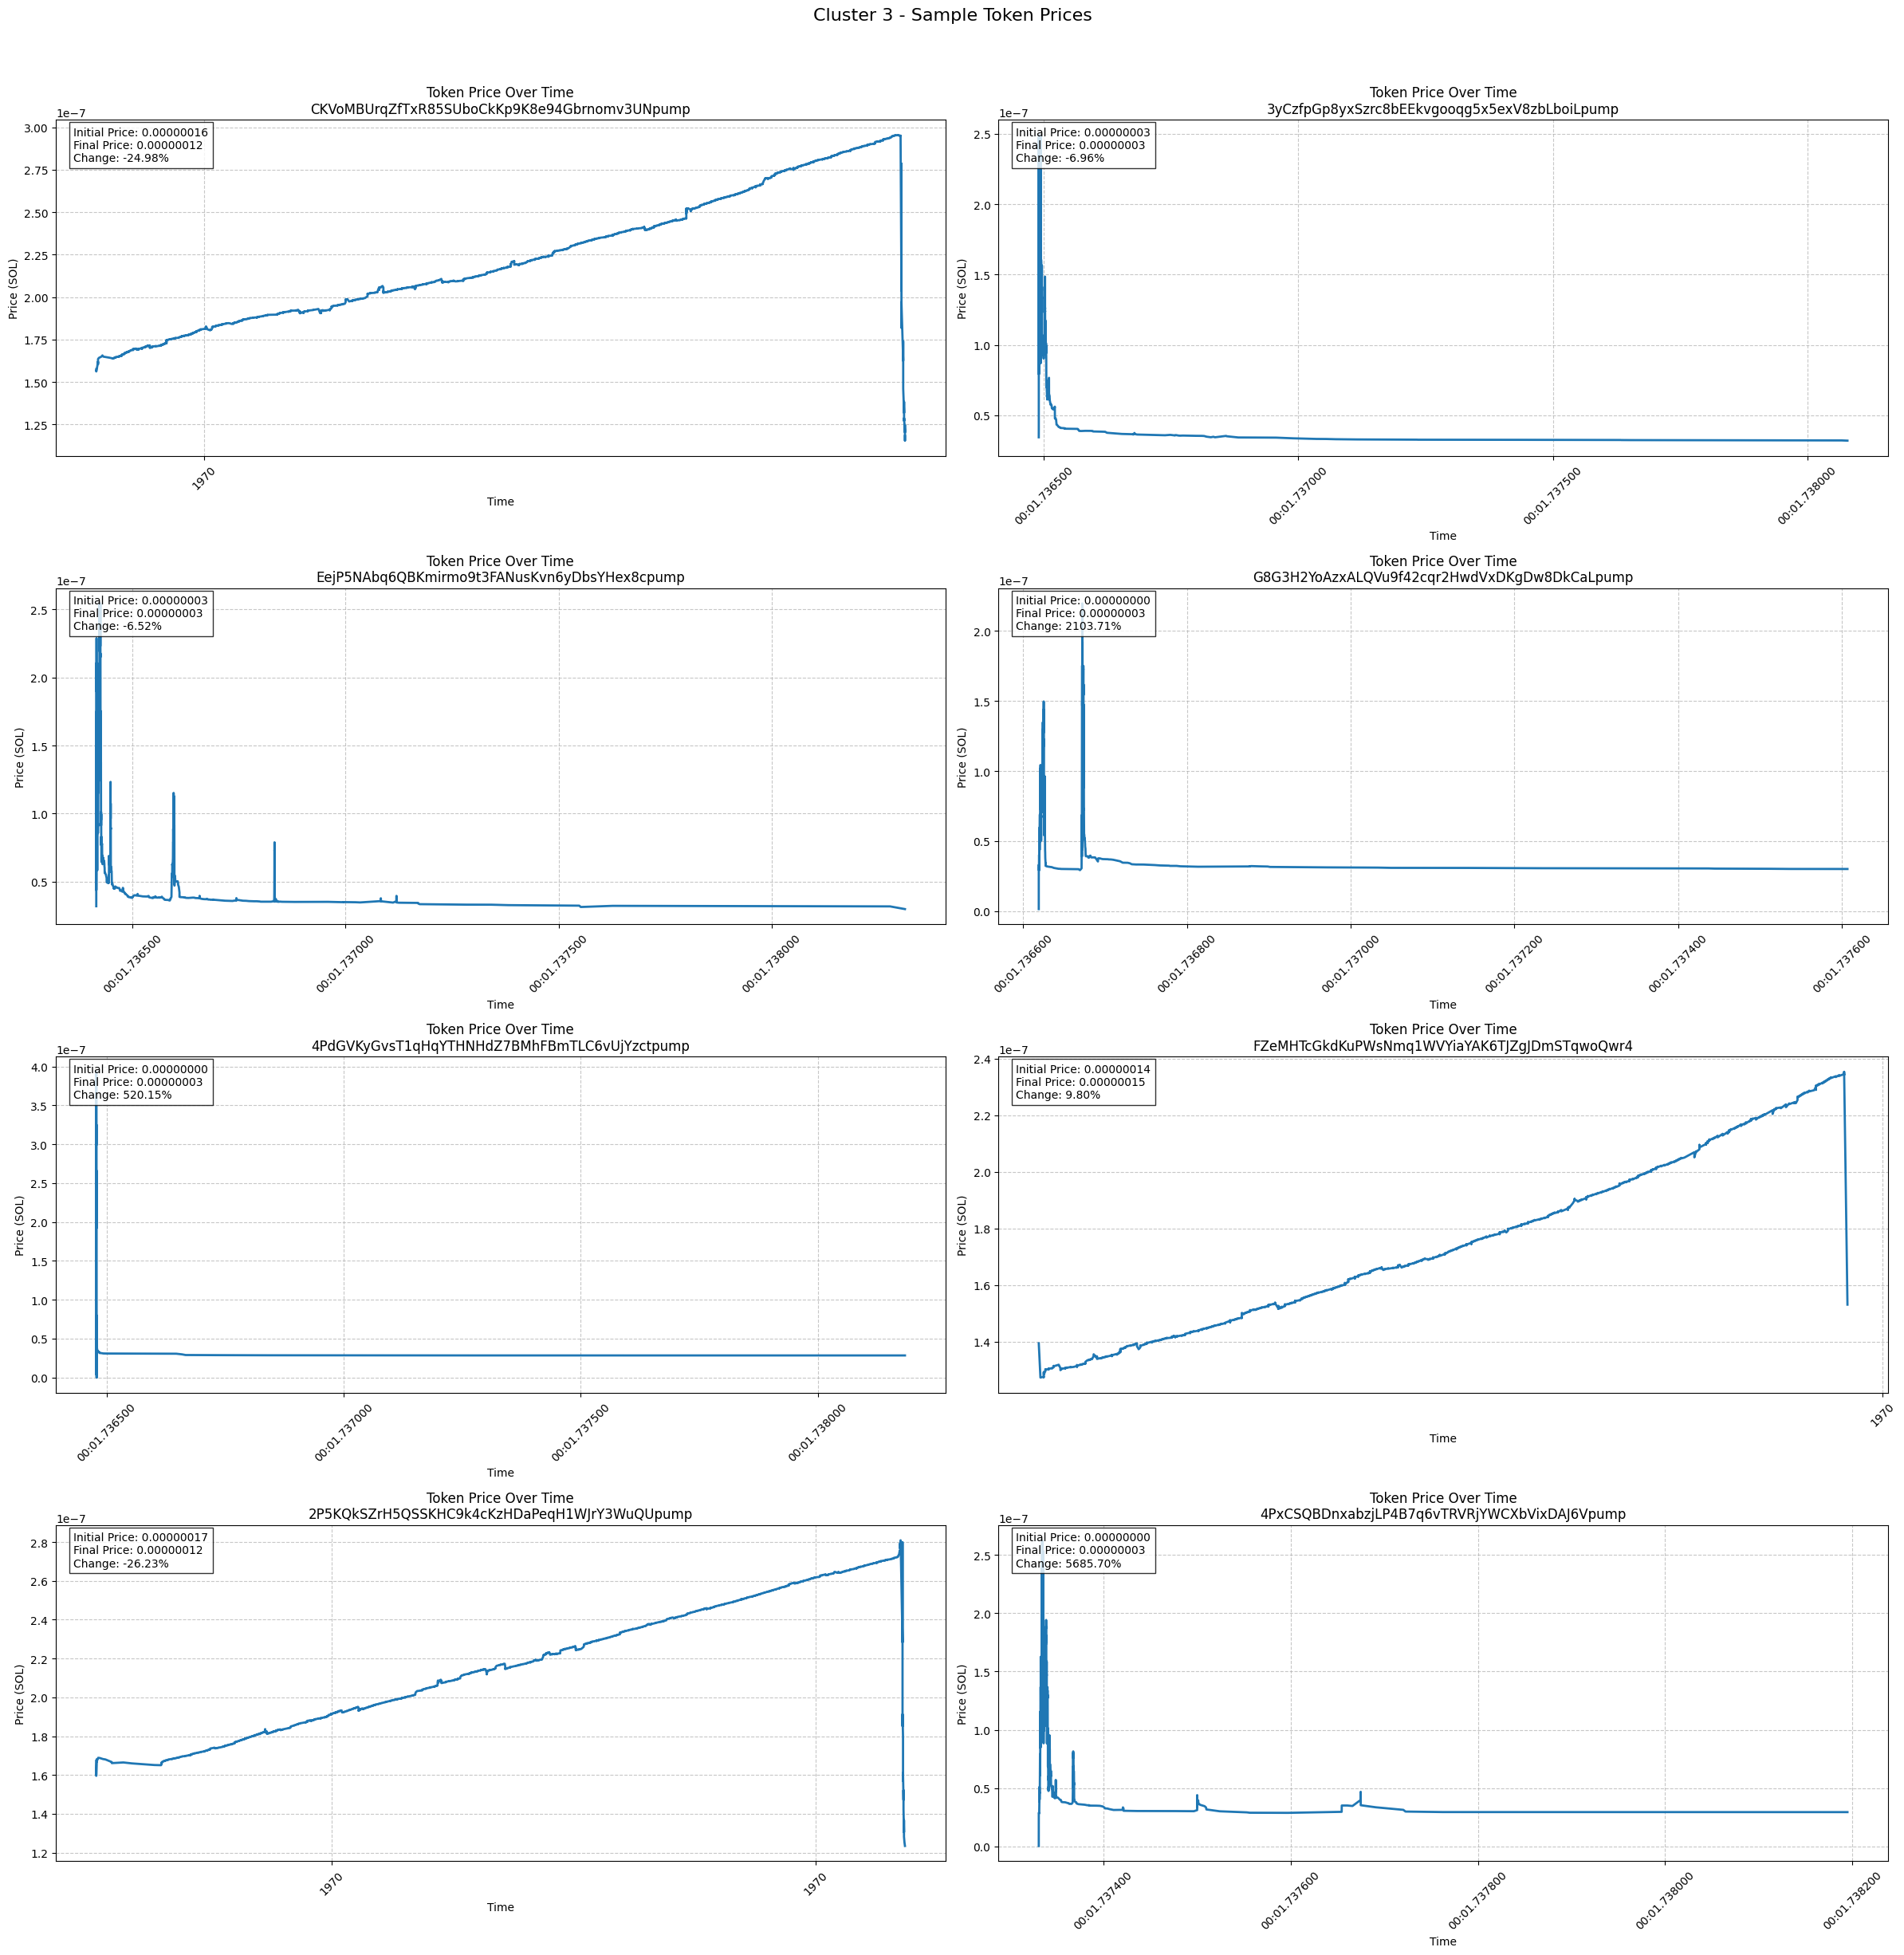

Created price plot for 8 tokens from cluster 3


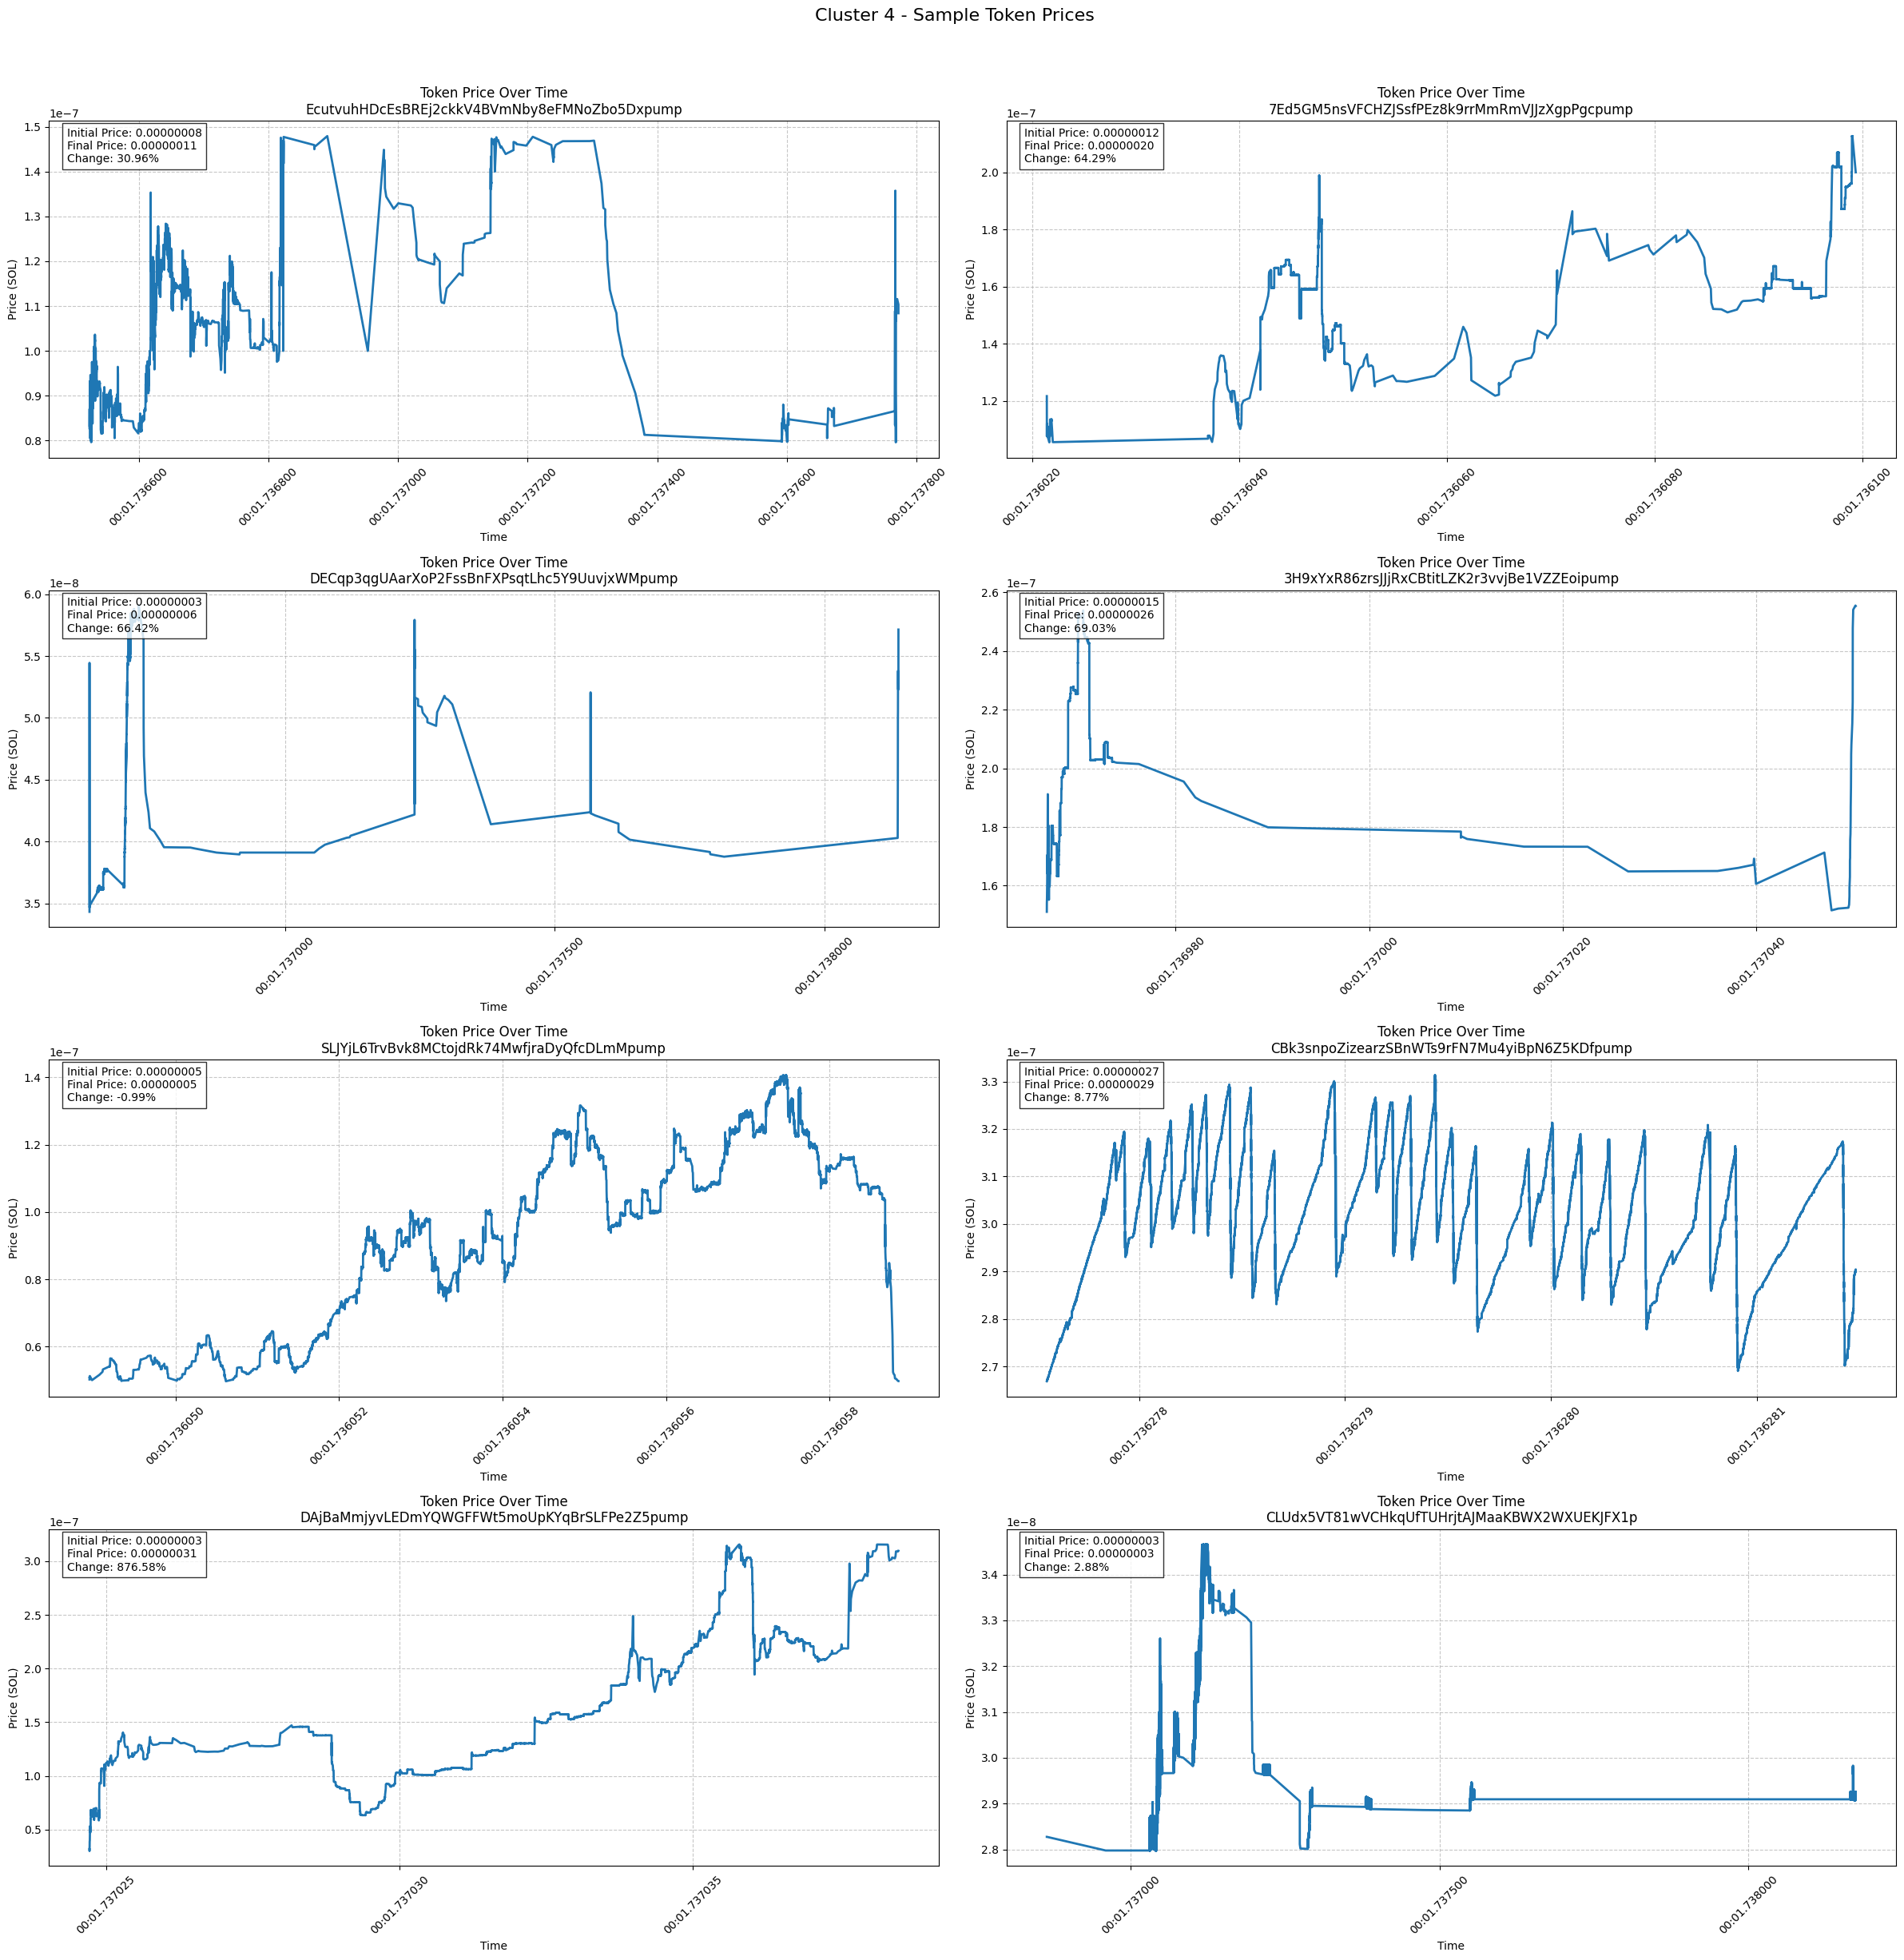

Created price plot for 8 tokens from cluster 4


In [13]:
# For each cluster, plot 8 random tokens
for cluster_id in range(best_k):
    # Filter the dataframe to get only tokens in this cluster
    cluster_tokens = df[df['cluster'] == cluster_id]
    
    # Make sure we don't try to sample more tokens than we have
    sample_size = min(8, len(cluster_tokens))
    
    if sample_size > 0:
        # Sample 8 random tokens (or fewer if the cluster has less than 8)
        random_tokens = cluster_tokens.sample(n=sample_size, random_state=42)
        
        # Get the token addresses
        token_addresses = random_tokens['token_address'].tolist()
        
        # Plot the tokens
        plot_title = f"Cluster {cluster_id} - Sample Token Prices"
        plot_token_price(token_addresses, title=plot_title)
        
        print(f"Created price plot for {sample_size} tokens from cluster {cluster_id}")
    else:
        print(f"Cluster {cluster_id} is empty, no plot created")

# Manual analysis

### Cluster 0 is very small so outliers
### Cluster 1 seems to be tokens were price is being inflated by creator aka scam
### Cluster 2 seems to contain normally traded tokens
### Cluster 3 seems to be a mix of 1 and 2 so it could be our feature vectors aren't great at capturing token lifecycle
### Cluster 4 very small group but seems to be tokens traded for long periods of time with low volatility and trade size, may be regular tokens


# Going forward

### I think an approach where we first identify phases in each tokens lifecycle for example launch and peak and get features of these on top of overall
### features

## Example feature vector

## LAUNCH METRICS
### early trade frequency
### early unique traders
### initial price momentum

## PEAK METRICS
### peak trade frequency
### time to peak
### peak trader count

## OVERALL METRICS
### max market cap
### price volatility
### total trades
### MAYBE LIFTETIME SECONDS but dead tokens where random holder sells days or weeks later messes up this metric


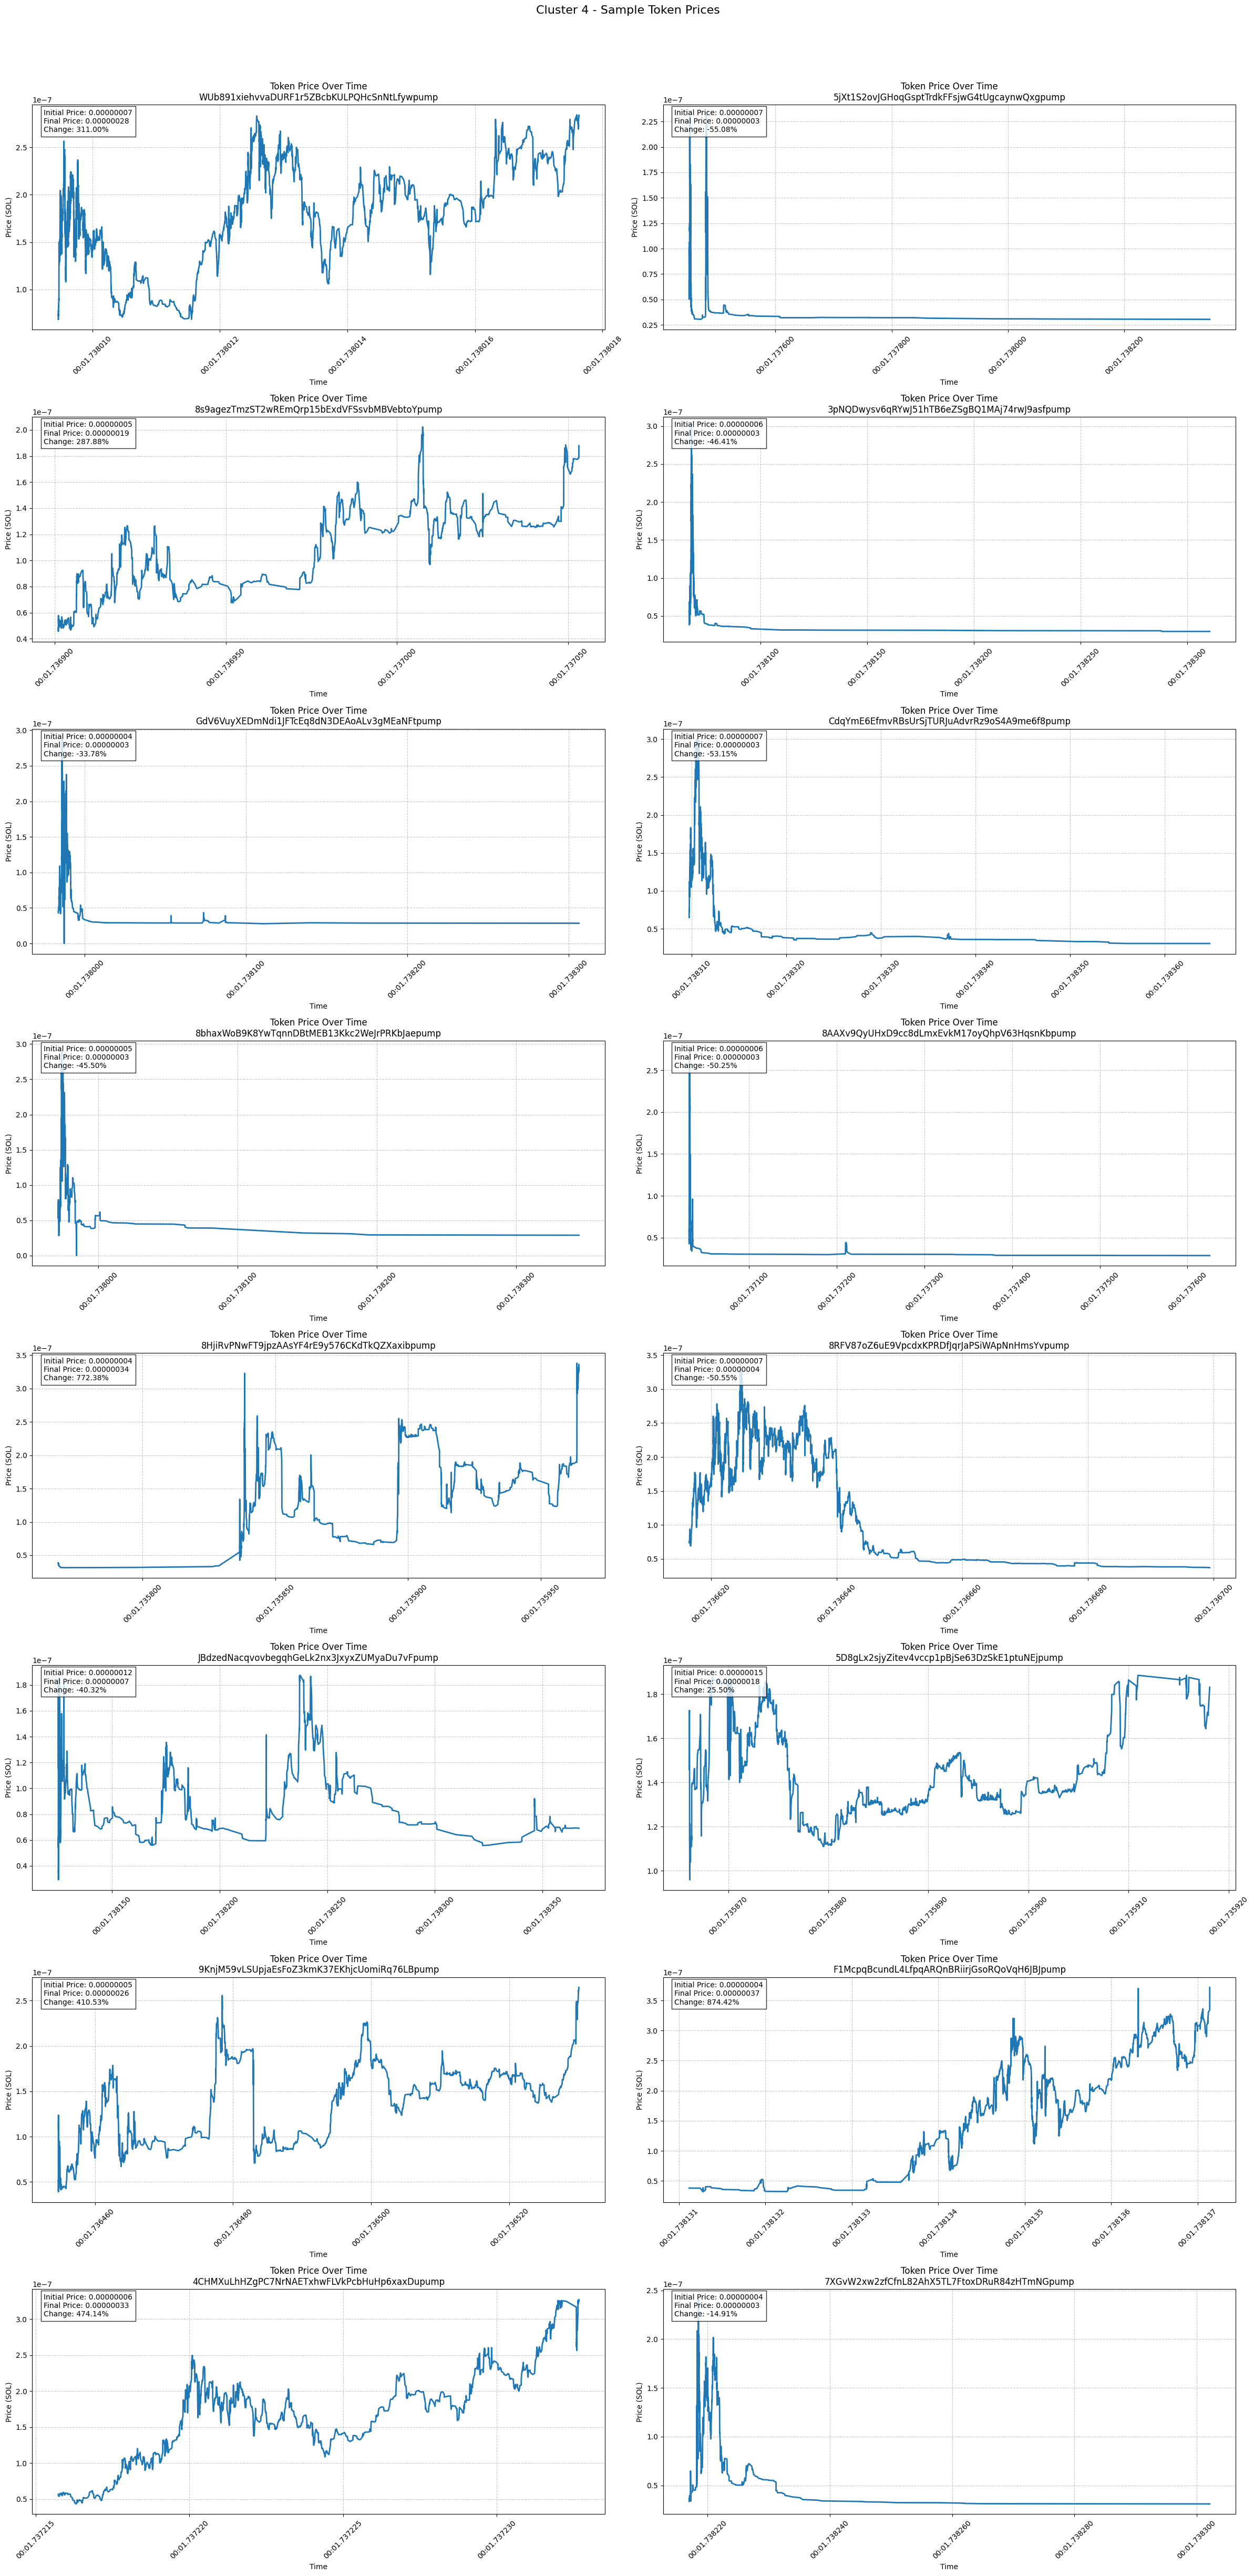

Created price plot for 16 tokens from cluster 4


In [14]:
# Further view on cluster 2 with dead period trimmed off

cluster_tokens = df[df['cluster'] == 2]
    
# Make sure we don't try to sample more tokens than we have
sample_size = min(16, len(cluster_tokens))

# Sample 16 random tokens (or fewer if the cluster has less than 16)
random_tokens = cluster_tokens.sample(n=sample_size, random_state=42)

# Get the token addresses
token_addresses = random_tokens['token_address'].tolist()

# Plot the tokens
plot_title = f"Cluster {cluster_id} - Sample Token Prices"
plot_token_price(token_addresses, title=plot_title, trim_dead_period=True)

print(f"Created price plot for {sample_size} tokens from cluster {cluster_id}")